In [1]:
from pandas import read_csv, Grouper, DataFrame, concat
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
from pandas import datetime
from datetime import datetime
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.tsa.holtwinters as ets
import statsmodels.tools.eval_measures as fa
from sklearn.metrics import  mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [2]:
#Sparkling dataset
#Q1
# Read the time series data

spark  =  read_csv('Sparkling.csv')

In [3]:
spark.head()

,YearMonth,Sparkling
0,1980-01,1686
1,1980-02,1591
2,1980-03,2304
3,1980-04,1712
4,1980-05,1471


In [4]:
spark.tail()

,YearMonth,Sparkling
182,1995-03,1897
183,1995-04,1862
184,1995-05,1670
185,1995-06,1688
186,1995-07,2031


In [5]:
spark.drop(labels='YearMonth',inplace=True,axis=1)

In [6]:
date = pd.date_range(start='1980/01/01', end='1995/08/01', freq='M')
date

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '1994-10-31', '1994-11-30', '1994-12-31', '1995-01-31',
               '1995-02-28', '1995-03-31', '1995-04-30', '1995-05-31',
               '1995-06-30', '1995-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [7]:
len(date)

187

In [8]:
spark['YearMonth'] = pd.DataFrame(date)

In [9]:
spark.set_index(keys='YearMonth',inplace=True,drop=True)
spark.head()

,Sparkling
YearMonth,
1980-01-31,1686
1980-02-29,1591
1980-03-31,2304
1980-04-30,1712
1980-05-31,1471


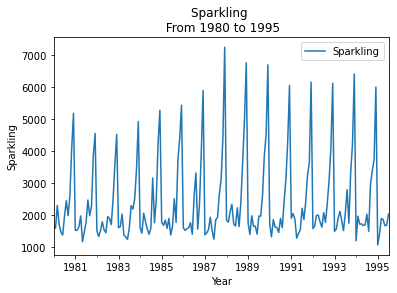

In [10]:
spark.plot()
plt.ylabel('Sparkling')
plt.xlabel('Year')
plt.title('Sparkling \n From 1980 to 1995')
plt.show()

In [11]:
#Q2
#EDA

spark.isnull().sum()

Sparkling    0
dtype: int64

In [12]:
spark.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-31 to 1995-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [13]:
print("The number of rows: ",spark.shape[0], "\n""The number of columns: ",spark.shape[1])

The number of rows:  187 
The number of columns:  1


In [14]:
spark.describe()

,Sparkling
count,187.000000
mean,2402.417112
std,1295.111540
min,1070.000000
25%,1605.000000
50%,1874.000000
75%,2549.000000
max,7242.000000


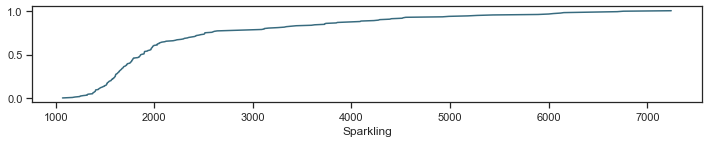

In [15]:
## Plot ECDF: Empirical Cumulative Distribution Function
#ECDF - Adds up the number of observations that are there for a certain value.
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

  
plt.subplot(312)
cdf = ECDF(spark['Sparkling'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sparkling');

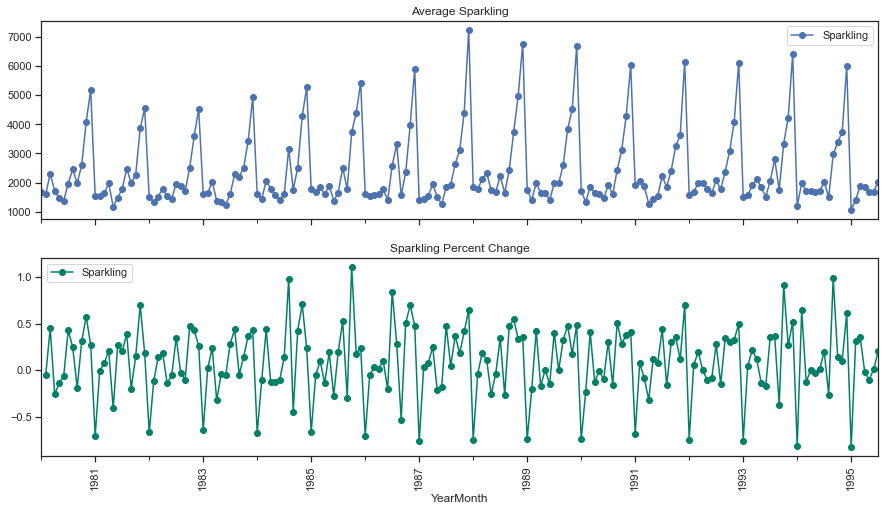

In [16]:
# group by YearMonth, get its average Sparkling and its percent change
average_sparkling    = spark.groupby('YearMonth')["Sparkling"].mean()
pct_change_sparkling = spark.groupby('YearMonth')["Sparkling"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average sparkling over time(year-month)
ax1 = average_sparkling.plot(legend=True,ax=axis1,marker='o',title="Average Sparkling")
ax1.set_xticks(range(len(average_sparkling)))
ax1.set_xticklabels(average_sparkling.index.tolist(), rotation=90)
# plot precent change for sparkling over time(year-month)
ax2 = pct_change_sparkling.plot(legend=True,ax=axis2,marker='o',rot=90,colormap="summer",title="Sparkling Percent Change")


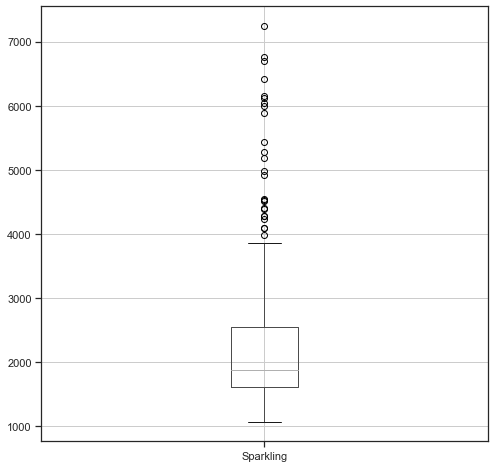

In [17]:
spark.boxplot(column="Sparkling",return_type='axes',figsize=(8,8))

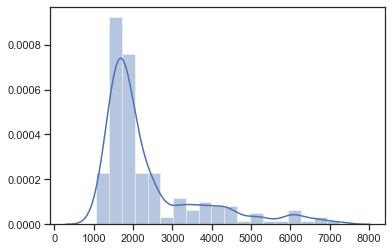

In [18]:
sns.distplot(spark)

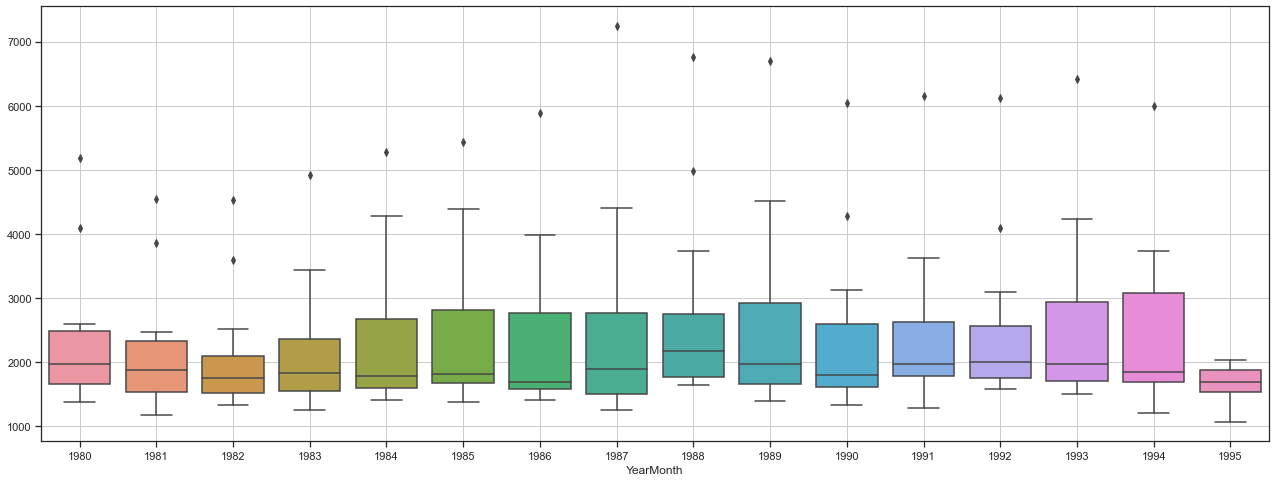

In [19]:
#yearly
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = spark.index.year,y = spark.values[:,0],ax=ax)
plt.grid();

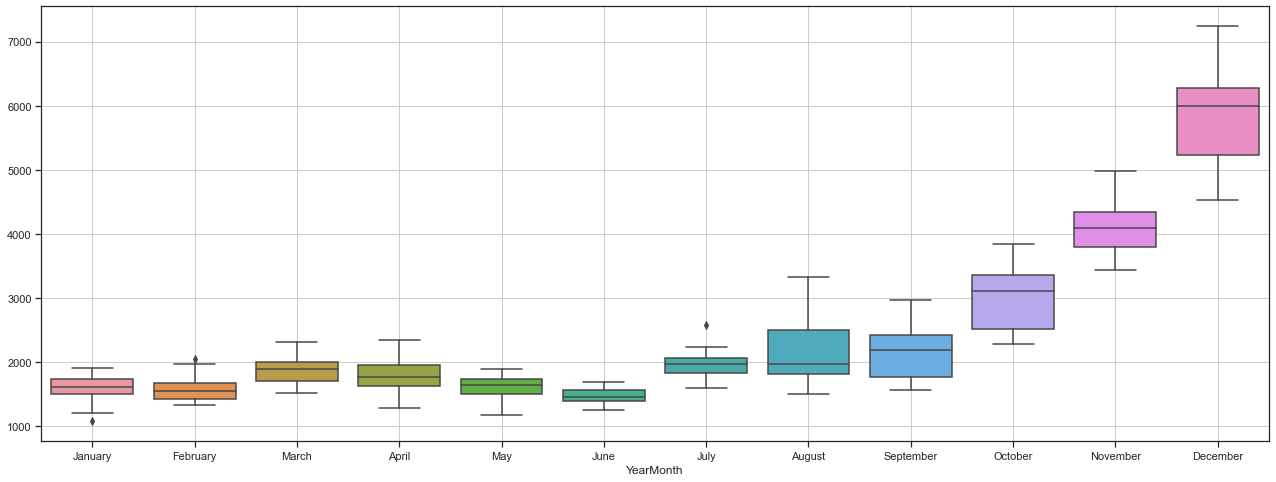

In [20]:
#monthly
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = spark.index.month_name(),y = spark.values[:,0],ax=ax)
plt.grid();

In [21]:
monthly_sparkling_across_years = pd.pivot_table(spark, values = 'Sparkling', columns = spark.index.month_name(), index = spark.index.year)
monthly_sparkling_across_years

YearMonth,April,August,December,February,January,July,June,March,May,November,October,September
YearMonth,,,,,,,,,,,,
1980,1712.0,2453.0,5179.0,1591.0,1686.0,1966.0,1377.0,2304.0,1471.0,4087.0,2596.0,1984.0
1981,1976.0,2472.0,4551.0,1523.0,1530.0,1781.0,1480.0,1633.0,1170.0,3857.0,2273.0,1981.0
1982,1790.0,1897.0,4524.0,1329.0,1510.0,1954.0,1449.0,1518.0,1537.0,3593.0,2514.0,1706.0
1983,1375.0,2298.0,4923.0,1638.0,1609.0,1600.0,1245.0,2030.0,1320.0,3440.0,2511.0,2191.0
1984,1789.0,3159.0,5274.0,1435.0,1609.0,1597.0,1404.0,2061.0,1567.0,4273.0,2504.0,1759.0
1985,1589.0,2512.0,5434.0,1682.0,1771.0,1645.0,1379.0,1846.0,1896.0,4388.0,3727.0,1771.0
1986,1605.0,3318.0,5891.0,1523.0,1606.0,2584.0,1403.0,1577.0,1765.0,3987.0,2349.0,1562.0
1987,1935.0,1930.0,7242.0,1442.0,1389.0,1847.0,1250.0,1548.0,1518.0,4405.0,3114.0,2638.0
1988,2336.0,1645.0,6757.0,1779.0,1853.0,2230.0,1661.0,2108.0,1728.0,4988.0,3740.0,2421.0


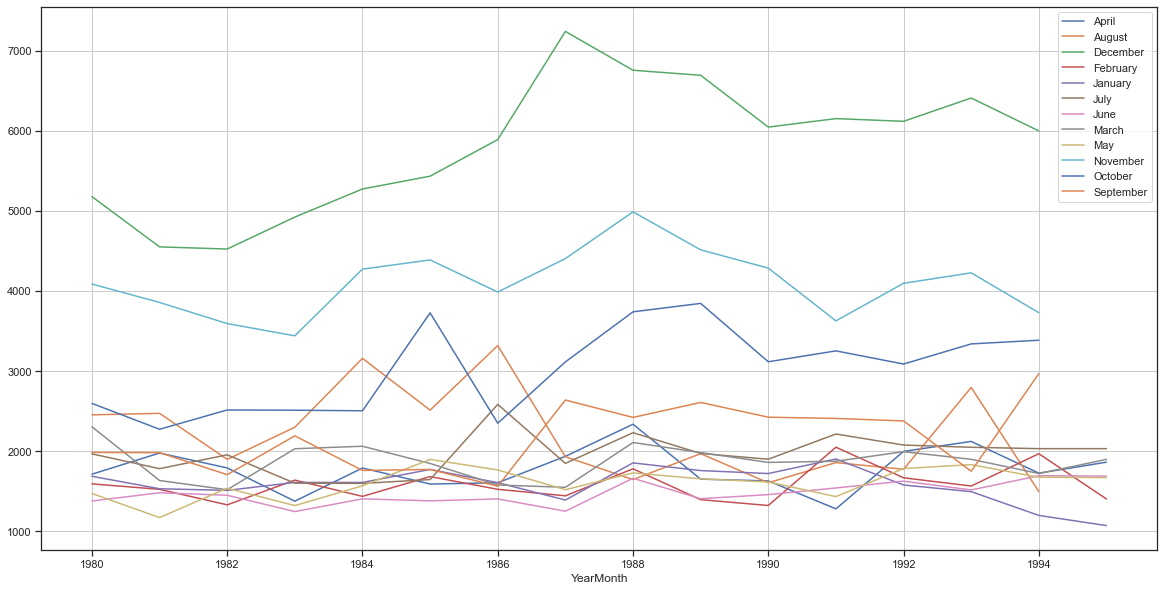

In [22]:
monthly_sparkling_across_years.plot(figsize=(20,10))
plt.grid()
plt.legend(loc='best');

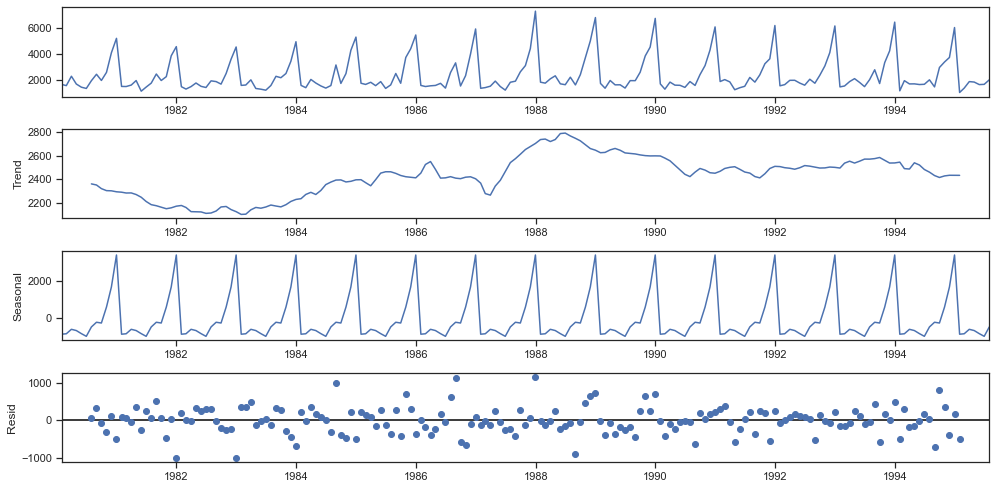

In [23]:
#Decomposition
rcParams['figure.figsize'] = 14, 7
sparkling_decomposition_additive = sm.tsa.seasonal_decompose(spark,model='additive')
sparkling_decomposition_additive.plot();

In [24]:
sparkling_trend_additive = sparkling_decomposition_additive.trend
sparkling_seasonal_additive = sparkling_decomposition_additive.seasonal
sparkling_residual_additive = sparkling_decomposition_additive.resid

In [25]:
print(sparkling_trend_additive.head(12))
print(sparkling_seasonal_additive.head(12))
print(sparkling_residual_additive.head(12))

YearMonth
1980-01-31            NaN
1980-02-29            NaN
1980-03-31            NaN
1980-04-30            NaN
1980-05-31            NaN
1980-06-30            NaN
1980-07-31    2360.666667
1980-08-31    2351.333333
1980-09-30    2320.541667
1980-10-31    2303.583333
1980-11-30    2302.041667
1980-12-31    2293.791667
Name: trend, dtype: float64
YearMonth
1980-01-31    -854.260599
1980-02-29    -830.350678
1980-03-31    -592.356630
1980-04-30    -658.490559
1980-05-31    -824.416154
1980-06-30    -967.434011
1980-07-31    -465.502265
1980-08-31    -214.332821
1980-09-30    -254.677265
1980-10-31     599.769957
1980-11-30    1675.067179
1980-12-31    3386.983846
Name: seasonal, dtype: float64
YearMonth
1980-01-31           NaN
1980-02-29           NaN
1980-03-31           NaN
1980-04-30           NaN
1980-05-31           NaN
1980-06-30           NaN
1980-07-31     70.835599
1980-08-31    315.999487
1980-09-30    -81.864401
1980-10-31   -307.353290
1980-11-30    109.891154
1980-12-31  

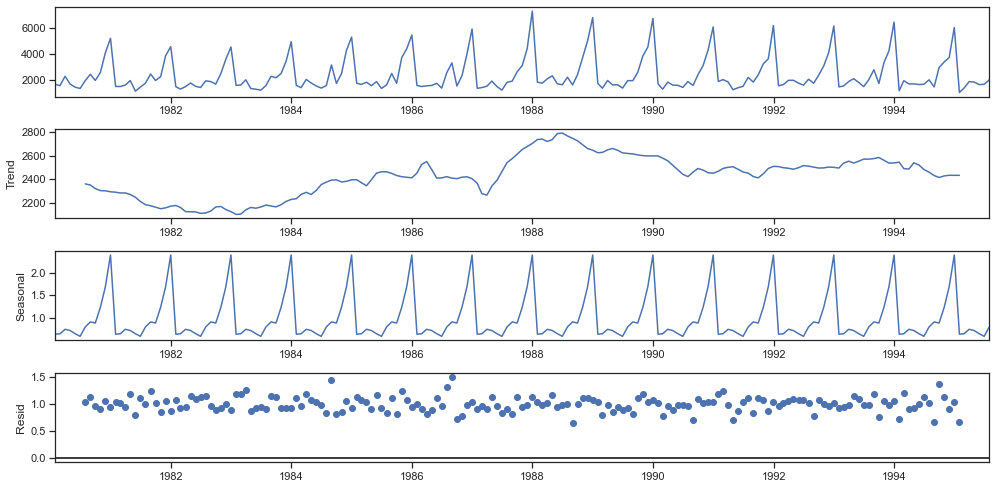

In [26]:
rcParams['figure.figsize'] = 14, 7
sparkling_decomposition_multiplicative = sm.tsa.seasonal_decompose(spark,model='multiplicative')
sparkling_decomposition_multiplicative.plot();

In [27]:
sparkling_trend_multiplicative = sparkling_decomposition_multiplicative.trend
sparkling_seasonal_multiplicative = sparkling_decomposition_multiplicative.seasonal
sparkling_residual_multiplicative = sparkling_decomposition_multiplicative.resid

In [28]:
print(sparkling_trend_multiplicative.head(12))
print(sparkling_seasonal_multiplicative.head(12))
print(sparkling_residual_multiplicative.head(12))

YearMonth
1980-01-31            NaN
1980-02-29            NaN
1980-03-31            NaN
1980-04-30            NaN
1980-05-31            NaN
1980-06-30            NaN
1980-07-31    2360.666667
1980-08-31    2351.333333
1980-09-30    2320.541667
1980-10-31    2303.583333
1980-11-30    2302.041667
1980-12-31    2293.791667
Name: trend, dtype: float64
YearMonth
1980-01-31    0.649843
1980-02-29    0.659214
1980-03-31    0.757440
1980-04-30    0.730351
1980-05-31    0.660609
1980-06-30    0.603468
1980-07-31    0.809164
1980-08-31    0.918822
1980-09-30    0.894367
1980-10-31    1.241789
1980-11-30    1.690158
1980-12-31    2.384776
Name: seasonal, dtype: float64
YearMonth
1980-01-31         NaN
1980-02-29         NaN
1980-03-31         NaN
1980-04-30         NaN
1980-05-31         NaN
1980-06-30         NaN
1980-07-31    1.029230
1980-08-31    1.135407
1980-09-30    0.955954
1980-10-31    0.907513
1980-11-30    1.050423
1980-12-31    0.946770
Name: resid, dtype: float64


In [29]:
#Q3
train_spark = spark[spark.index < '1991-01-01']
test_spark = spark[spark.index >= '1991-01-01']

In [30]:
print(train_spark.shape)
print(test_spark.shape)

(132, 1)
(55, 1)


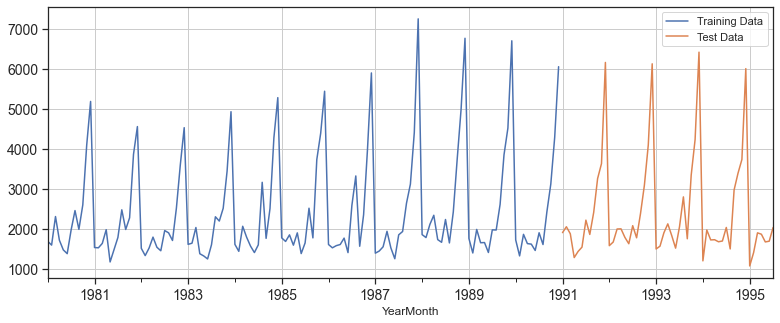

In [31]:
train_spark['Sparkling'].plot(figsize=(13,5), fontsize=14)
test_spark['Sparkling'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [32]:
#Q4
#Simple Exponential Smothing
SES_train_spark = train_spark.copy()
SES_test_spark = test_spark.copy()

In [33]:
model_SES_spark = SimpleExpSmoothing(SES_train_spark['Sparkling'])

In [34]:
model_SES_autofit_spark = model_SES_spark.fit(optimized=True)

In [35]:
model_SES_autofit_spark.params_formatted

,name,param,optimized
smoothing_level,alpha,0.000000,True
initial_level,l.0,2403.785622,True


In [36]:
SES_train_spark['predict'] = model_SES_autofit_spark.fittedvalues
SES_train_spark.head()

,Sparkling,predict
YearMonth,,
1980-01-31,1686,2403.785622
1980-02-29,1591,2403.785622
1980-03-31,2304,2403.785622
1980-04-30,1712,2403.785622
1980-05-31,1471,2403.785622


In [37]:
SES_test_spark['predict'] = model_SES_autofit_spark.forecast(steps=len(test_spark))
SES_test_spark['predict'].head()

YearMonth
1991-01-31    2403.785622
1991-02-28    2403.785622
1991-03-31    2403.785622
1991-04-30    2403.785622
1991-05-31    2403.785622
Name: predict, dtype: float64

In [38]:
# Mean Absolute Percentage Error - Function Definition

def MAPE(y, yhat): 
    y, yhat = np.array(y), np.array(yhat)
    try:
        mape =  round(np.sum(np.abs(yhat - y)) / np.sum(y) * 100,2)
    except:
        print("Observed values are empty")
        mape = np.nan
    return mape

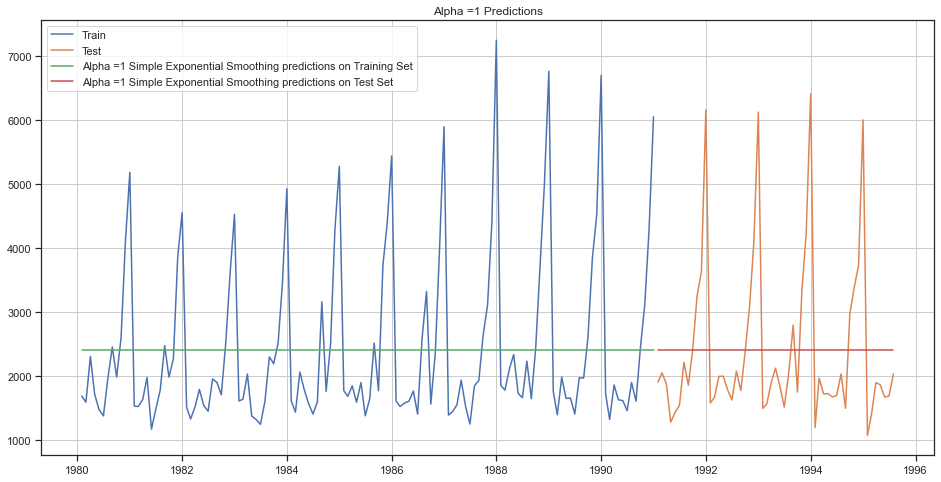

In [39]:
# Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train_spark['Sparkling'], label='Train')
plt.plot(SES_test_spark['Sparkling'], label='Test')

plt.plot(SES_train_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Training Set')
plt.plot(SES_test_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =1 Predictions');

In [40]:
# Training Data

rmse_spark_train_SES = metrics.mean_squared_error(SES_train_spark['Sparkling'],SES_train_spark['predict'],squared=False)
mape_spark_train_SES = MAPE(SES_train_spark['Sparkling'],SES_train_spark['predict'])
print("For Alpha =1 Simple Exponential Smoothing Model forecast on the Training Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_train_SES, mape_spark_train_SES))

For Alpha =1 Simple Exponential Smoothing Model forecast on the Training Data,  RMSE is 1298.484 MAPE is 40.36


In [41]:
# Test Data

rmse_spark_test_SES = metrics.mean_squared_error(SES_test_spark['Sparkling'],SES_test_spark['predict'],squared=False)
mape_spark_test_SES = MAPE(SES_test_spark['Sparkling'],SES_test_spark['predict'])
print("For Alpha =1 Simple Exponential Smoothing Model forecast on the Testing Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_SES, mape_spark_test_SES))

For Alpha =1 Simple Exponential Smoothing Model forecast on the Testing Data,  RMSE is 1275.082 MAPE is 38.90


In [42]:
resultsDf_spark = pd.DataFrame({'Test RMSE': [rmse_spark_test_SES],'Test MAPE': [mape_spark_test_SES]}
                           ,index=['Alpha=1,SimpleExponentialSmoothing'])

In [43]:
# First we will define an empty dataframe to store our values from the loop

results_spark_SES_loop = pd.DataFrame({'Alpha Values':[],'Train RMSE':[],'Train MAPE':[]
                                ,'Test RMSE': [],'Test MAPE': []})

In [44]:
for i in np.arange(0.1,1,0.1):
    model_SES_spark_alpha_i = model_SES_spark.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train_spark['predict',i] = model_SES_spark_alpha_i.fittedvalues
    SES_test_spark['predict',i] = model_SES_spark_alpha_i.forecast(steps=len(test_spark))
    
    rmse_spark_train_SES_i = metrics.mean_squared_error(SES_train_spark['Sparkling'],SES_train_spark['predict',i],squared=False)
    mape_spark_train_SES_i = MAPE(SES_train_spark['Sparkling'],SES_train_spark['predict',i])
    
    rmse_spark_test_SES_i = metrics.mean_squared_error(SES_test_spark['Sparkling'],SES_test_spark['predict',i],squared=False)
    mape_spark_test_SES_i = MAPE(SES_test_spark['Sparkling'],SES_test_spark['predict',i])
    
    results_spark_SES_loop = results_spark_SES_loop.append({'Alpha Values':i,'Train RMSE':rmse_spark_train_SES_i 
                                      ,'Train MAPE': mape_spark_train_SES_i,'Test RMSE':rmse_spark_test_SES_i
                                      ,'Test MAPE':mape_spark_test_SES_i}, ignore_index=True)

In [45]:
results_spark_SES_loop

,Alpha Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,0.1,1333.873836,42.03,1375.393398,49.53
1,0.2,1356.042987,43.79,1595.206839,60.46
2,0.3,1359.511747,43.73,1935.507132,75.66
3,0.4,1352.588879,42.75,2311.919615,91.55
4,0.5,1344.004369,41.16,2666.351413,106.27
5,0.6,1338.805381,39.80,2979.204388,118.77
6,0.7,1338.844308,38.55,3249.944092,129.34
7,0.8,1344.462091,37.60,3483.801006,138.34
8,0.9,1355.723518,36.79,3686.794285,146.08


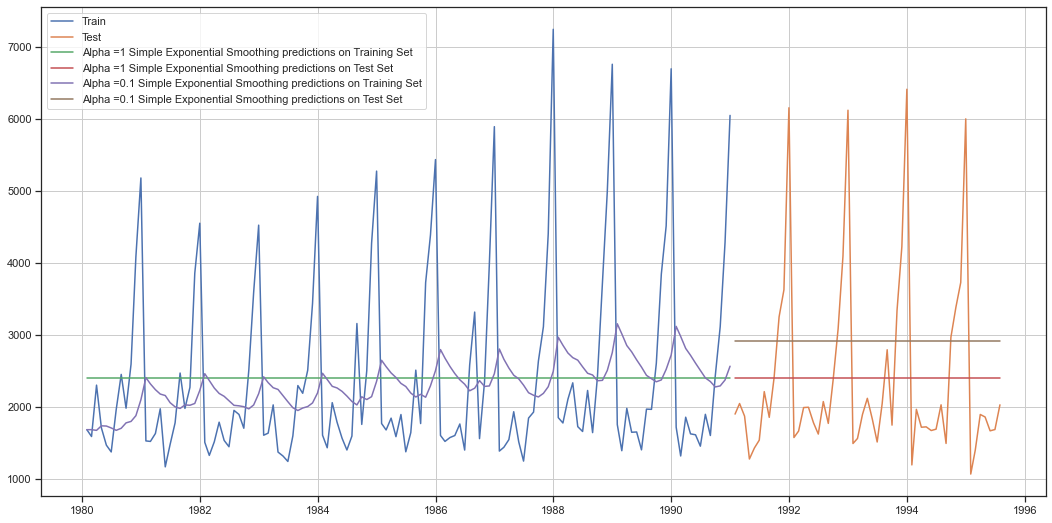

In [46]:
# Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train_spark['Sparkling'], label='Train')
plt.plot(SES_test_spark['Sparkling'], label='Test')

plt.plot(SES_train_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Training Set')
plt.plot(SES_test_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')

plt.plot(SES_train_spark['predict', 0.1], label='Alpha =0.1 Simple Exponential Smoothing predictions on Training Set')
plt.plot(SES_test_spark['predict', 0.1], label='Alpha =0.1 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();

In [47]:
results_spark_SES = pd.DataFrame({'Test RMSE': [results_spark_SES_loop['Test RMSE'][0]],'Test MAPE': [results_spark_SES_loop['Test MAPE'][0]]}
                           ,index=['Alpha=0.1,SimpleExponentialSmoothing'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_SES])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53


In [48]:
#Double Exponential Smoothing (Holt's Model)
DES_train_spark = train_spark.copy()
DES_test_spark = test_spark.copy()

In [49]:
model_DES_spark = Holt(DES_train_spark['Sparkling'])

In [50]:
model_DES_autofit_spark = model_DES_spark.fit(optimized=True,use_brute=True)

In [51]:
model_DES_autofit_spark.params_formatted

,name,param,optimized
smoothing_level,alpha,0.647792,True
smoothing_slope,beta,0.000000,True
initial_level,l.0,1686.083777,True
initial_slope,b.0,27.059653,True


In [52]:
DES_train_spark['predict'] = model_DES_autofit_spark.fittedvalues
DES_train_spark.head()

,Sparkling,predict
YearMonth,,
1980-01-31,1686,1713.143430
1980-02-29,1591,1722.619775
1980-03-31,2304,1664.417138
1980-04-30,1712,2105.793709
1980-05-31,1471,1877.756790


In [53]:
DES_test_spark['predict'] = model_DES_autofit_spark.forecast(steps=len(test_spark))
DES_test_spark['predict'].head()

YearMonth
1991-01-31    5281.439591
1991-02-28    5308.499244
1991-03-31    5335.558897
1991-04-30    5362.618550
1991-05-31    5389.678203
Name: predict, dtype: float64

In [54]:
# First we will define an empty dataframe to store our values from the loop

results_spark_DES_loop = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train RMSE':[],'Train MAPE':[]
                                ,'Test RMSE': [],'Test MAPE': []})

In [55]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        model_DES_spark_alpha_i_j = model_DES_spark.fit(smoothing_level=i,smoothing_slope=j,optimized=False,use_brute=True)
        DES_train_spark['predict',i,j] = model_DES_spark_alpha_i_j.fittedvalues
        DES_test_spark['predict',i,j] = model_DES_spark_alpha_i_j.forecast(steps=len(test_spark))
        
        rmse__spark_train_DES = metrics.mean_squared_error(DES_train_spark['Sparkling'],DES_train_spark['predict',i,j],squared=False)
        mape__spark_train_DES = MAPE(DES_train_spark['Sparkling'],DES_train_spark['predict',i,j])
        
        rmse__spark_test_DES = metrics.mean_squared_error(DES_test_spark['Sparkling'],DES_test_spark['predict',i,j],squared=False)
        mape__spark_test_DES = MAPE(DES_test_spark['Sparkling'],DES_test_spark['predict',i,j])
        
        results_spark_DES_loop = results_spark_DES_loop.append({'Alpha Values':i,'Beta Values':j,'Train RMSE':rmse__spark_train_DES
                                      ,'Train MAPE': mape__spark_train_DES,'Test RMSE':rmse__spark_test_DES
                                      ,'Test MAPE':mape__spark_test_DES}, ignore_index=True)

In [56]:
results_spark_DES_loop

,Alpha Values,Beta Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,0.1,0.1,1382.520870,44.37,1778.564670,67.20
1,0.1,0.2,1413.598835,46.14,2599.439986,95.43
2,0.1,0.3,1445.762015,47.43,4293.084674,155.43
3,0.1,0.4,1480.897776,48.79,6039.537339,218.98
4,0.1,0.5,1521.108657,50.34,7390.522201,267.94
...,...,...,...,...,...,...
95,1.0,0.6,1753.402326,45.75,49327.087977,1824.42
96,1.0,0.7,1825.187155,47.97,52655.765663,1945.23
97,1.0,0.8,1902.013709,50.11,55442.273880,2046.36
98,1.0,0.9,1985.368445,52.03,57823.177011,2132.75


In [57]:
results_spark_DES_loop.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,0.1,0.1,1382.520870,44.37,1778.564670,67.20
1,0.1,0.2,1413.598835,46.14,2599.439986,95.43
10,0.2,0.1,1418.041591,46.65,3611.763322,135.41
2,0.1,0.3,1445.762015,47.43,4293.084674,155.43
20,0.3,0.1,1431.169601,46.99,5908.185554,223.50


In [58]:
results_spark_DES_loop.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,0.1,0.1,1382.520870,44.37,1778.564670,67.20
1,0.1,0.2,1413.598835,46.14,2599.439986,95.43
10,0.2,0.1,1418.041591,46.65,3611.763322,135.41
2,0.1,0.3,1445.762015,47.43,4293.084674,155.43
3,0.1,0.4,1480.897776,48.79,6039.537339,218.98


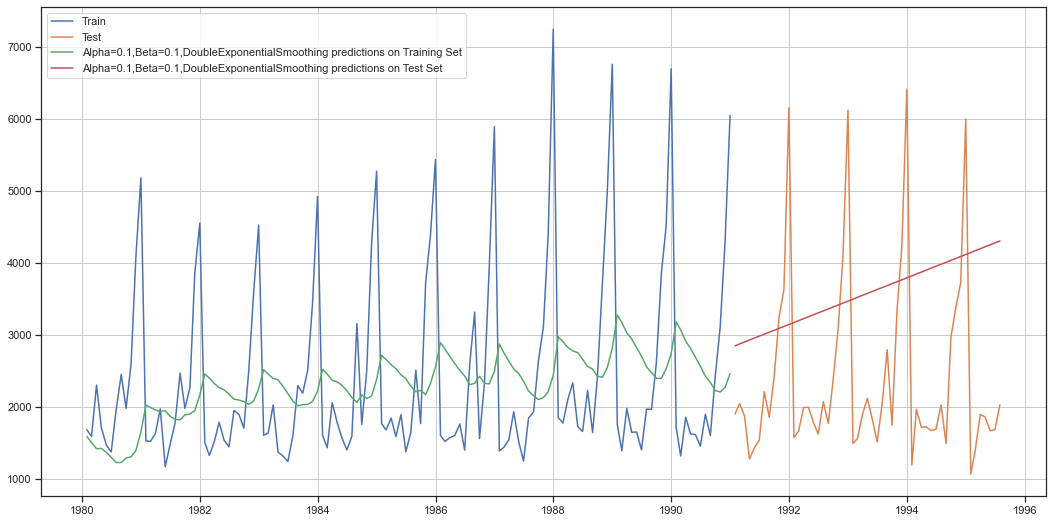

In [59]:
# Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train_spark['Sparkling'], label='Train')
plt.plot(DES_test_spark['Sparkling'], label='Test')

plt.plot(DES_train_spark['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing predictions on Training Set')
plt.plot(DES_test_spark['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [60]:
results_spark_DES = pd.DataFrame({'Test RMSE': [results_spark_DES_loop['Test RMSE'][0]],'Test MAPE':[results_spark_DES_loop['Test MAPE'][0]]}
                           ,index=['Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_DES])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20


In [61]:
TES_train_spark = train_spark.copy()
TES_test_spark = test_spark.copy()

In [62]:
model_TES_spark = ExponentialSmoothing(TES_train_spark['Sparkling'],trend='additive',seasonal='multiplicative',freq='M')

In [63]:
model_TES_spark_autofit = model_TES_spark.fit()

In [64]:
model_TES_spark_autofit.params

{'smoothing_level': 0.15420626100710186,
 'smoothing_slope': 5.31004588730174e-21,
 'smoothing_seasonal': 0.3713228125445634,
 'damping_slope': nan,
 'initial_level': 1639.99933972618,
 'initial_slope': 4.847695527861546,
 'initial_seasons': array([1.00842978, 0.96899514, 1.24181168, 1.13206716, 0.93979295,
        0.93811177, 1.22457951, 1.54428109, 1.27335495, 1.631977  ,
        2.48292059, 3.11861503]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [65]:
TES_train_spark['predict'] = model_TES_spark_autofit.fittedvalues
TES_train_spark.head()

,Sparkling,predict
YearMonth,,
1980-01-31,1686,1658.712732
1980-02-29,1591,1602.589494
1980-03-31,2304,2057.521470
1980-04-30,1712,1915.826449
1980-05-31,1471,1568.898762


In [66]:
TES_test_spark['predict'] = model_TES_spark_autofit.forecast(steps=len(test_spark))
TES_test_spark['predict'].head()

YearMonth
1991-01-31    1602.194523
1991-02-28    1373.889119
1991-03-31    1807.439476
1991-04-30    1704.573982
1991-05-31    1602.374672
Name: predict, dtype: float64

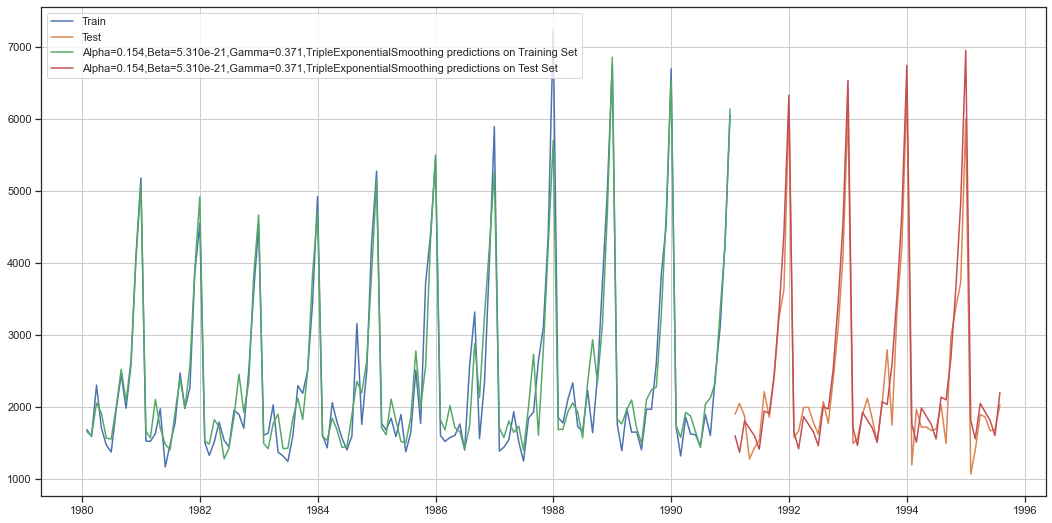

In [67]:
# Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train_spark['Sparkling'], label='Train')
plt.plot(TES_test_spark['Sparkling'], label='Test')

plt.plot(TES_train_spark['predict'], label='Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing predictions on Training Set')
plt.plot(TES_test_spark['predict'], label='Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [68]:
# Training Data

rmse_spark_train_TES = metrics.mean_squared_error(TES_train_spark['Sparkling'],TES_train_spark['predict'],squared=False)
mape_spark_train_TES = MAPE(TES_train_spark['Sparkling'],TES_train_spark['predict'])
print("Triple Exponential Smoothing Model forecast on the Training Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_train_TES, mape_spark_train_TES))

Triple Exponential Smoothing Model forecast on the Training Data,  RMSE is 353.379 MAPE is 10.17


In [69]:
# Test Data

rmse_spark_test_TES = metrics.mean_squared_error(TES_test_spark['Sparkling'],TES_test_spark['predict'],squared=False)
mape_spark_test_TES = MAPE(TES_test_spark['Sparkling'],TES_test_spark['predict'])
print("Triple Exponential Smoothing Model forecast on the Testing Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_TES, mape_spark_test_TES))

Triple Exponential Smoothing Model forecast on the Testing Data,  RMSE is 383.158 MAPE is 11.91


In [70]:
results_spark_TES = pd.DataFrame({'Test RMSE': [rmse_spark_test_TES],'Test MAPE':[mape_spark_test_TES]}
                           ,index=['Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_TES])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91


In [71]:
# First we will define an empty dataframe to store our values from the loop

results_spark_TES_loop = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train RMSE':[],'Train MAPE':[]
                                ,'Test RMSE': [],'Test MAPE': []})

In [72]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        for k in np.arange(0.1,1.1,0.1):
            model_TES_spark_alpha_i_j_k = model_TES_spark.fit(smoothing_level=i,smoothing_slope=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train_spark['predict',i,j,k] = model_TES_spark_alpha_i_j_k.fittedvalues
            TES_test_spark['predict',i,j,k] = model_TES_spark_alpha_i_j_k.forecast(steps=len(test_spark))
        
            rmse_spark_train_ijk = metrics.mean_squared_error(TES_train_spark['Sparkling'],TES_train_spark['predict',i,j,k],squared=False)
            mape_spark_train_ijk = MAPE(TES_train_spark['Sparkling'],TES_train_spark['predict',i,j,k])
        
            rmse_spark_test_ijk = metrics.mean_squared_error(TES_test_spark['Sparkling'],TES_test_spark['predict',i,j,k],squared=False)
            mape_spark_test_ijk = MAPE(TES_test_spark['Sparkling'],TES_test_spark['predict',i,j,k])
        
            results_spark_TES_loop = results_spark_TES_loop.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,'Train RMSE':rmse_spark_train_ijk
                                      ,'Train MAPE': mape_spark_train_ijk,'Test RMSE':rmse_spark_test_ijk
                                      ,'Test MAPE':mape_spark_test_ijk}, ignore_index=True)

In [73]:
results_spark_TES_loop

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
0,0.1,0.1,0.1,388.351959,11.31,5.799963e+02,19.22
1,0.1,0.1,0.2,372.002250,10.82,6.174690e+02,20.80
2,0.1,0.1,0.3,364.222099,10.57,6.387802e+02,21.67
3,0.1,0.1,0.4,362.590749,10.51,6.447620e+02,22.22
4,0.1,0.1,0.5,365.655545,10.59,6.411226e+02,22.29
...,...,...,...,...,...,...,...
995,1.0,1.0,0.6,153394.791827,1428.87,7.989790e+05,17177.41
996,1.0,1.0,0.7,94040.964957,1036.30,1.074413e+06,28878.00
997,1.0,1.0,0.8,102196.953755,888.48,5.010607e+06,65738.32
998,1.0,1.0,0.9,77924.294413,876.07,4.318265e+05,6048.85


In [74]:
results_spark_TES_loop.sort_values(by=['Test RMSE']).head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
301,0.4,0.1,0.2,389.772245,11.00,336.715250,10.56
211,0.3,0.2,0.2,395.529174,11.09,350.145204,11.08
110,0.2,0.2,0.1,405.333164,11.47,352.571689,11.28
200,0.3,0.1,0.1,394.630053,11.32,352.607849,11.11
20,0.1,0.3,0.1,414.423963,11.48,354.534561,11.77


In [75]:
results_spark_TES_loop.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Gamma Values,Train RMSE,Train MAPE,Test RMSE,Test MAPE
301,0.4,0.1,0.2,389.772245,11.00,336.715250,10.56
211,0.3,0.2,0.2,395.529174,11.09,350.145204,11.08
200,0.3,0.1,0.1,394.630053,11.32,352.607849,11.11
110,0.2,0.2,0.1,405.333164,11.47,352.571689,11.28
20,0.1,0.3,0.1,414.423963,11.48,354.534561,11.77


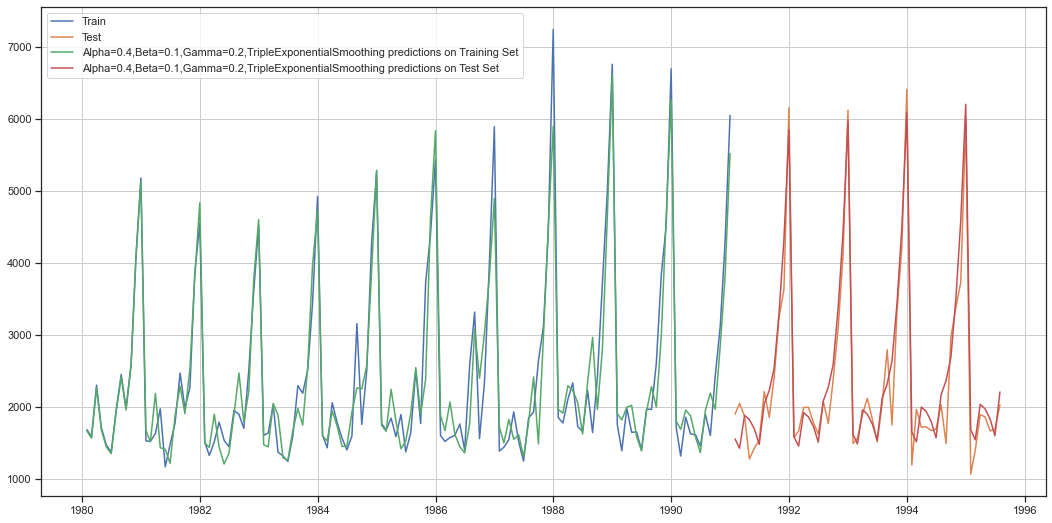

In [76]:
# Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train_spark['Sparkling'], label='Train')
plt.plot(TES_test_spark['Sparkling'], label='Test')

plt.plot(TES_train_spark['predict', 0.4, 0.1, 0.2], label='Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing predictions on Training Set')
#The value of alpha and beta is taken like that by python
plt.plot(TES_test_spark['predict', 0.4, 0.1, 0.2], label='Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [77]:
results_spark_TES_1 = pd.DataFrame({'Test RMSE': [results_spark_TES_loop['Test RMSE'][301]],'Test MAPE':[results_spark_TES_loop['Test MAPE'][301]]}
                           ,index=['Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_TES_1])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56


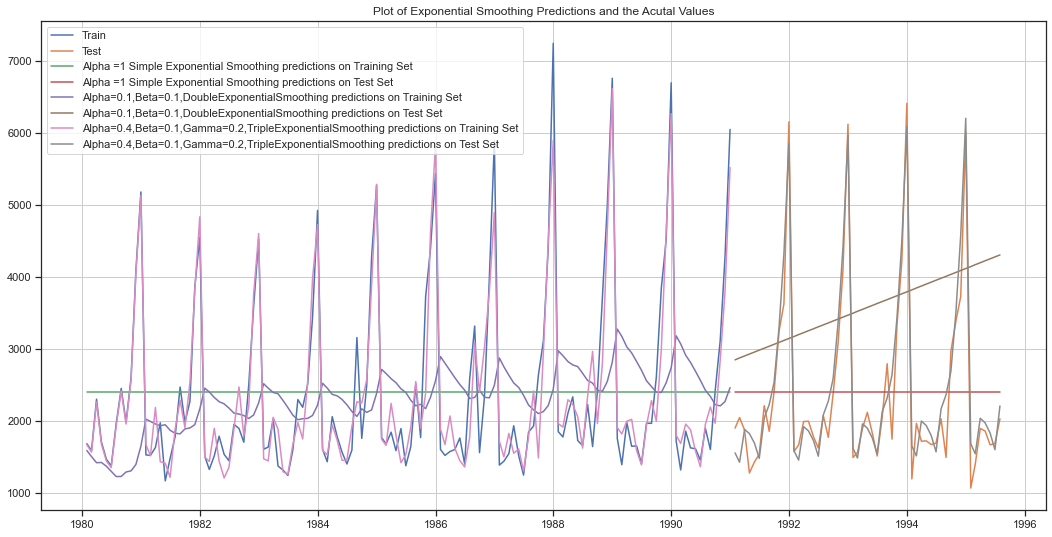

In [78]:
# Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(train_spark['Sparkling'], label='Train')
plt.plot(test_spark['Sparkling'], label='Test')

plt.plot(SES_train_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Training Set')
plt.plot(SES_test_spark['predict'], label='Alpha =1 Simple Exponential Smoothing predictions on Test Set')

plt.plot(DES_train_spark['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing predictions on Training Set')
plt.plot(DES_test_spark['predict', 0.1, 0.1], label='Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing predictions on Test Set')

plt.plot(TES_train_spark['predict', 0.4, 0.1, 0.2], label='Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing predictions on Training Set')
plt.plot(TES_test_spark['predict', 0.4, 0.1, 0.2], label='Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid();
plt.title('Plot of Exponential Smoothing Predictions and the Acutal Values');

In [79]:
#Linear Regression
train_time_spark = [i+1 for i in range(len(train_spark))]
test_time_spark = [i+133 for i in range(len(test_spark))]
print('Training Time instance','\n',train_time_spark)
print('Test Time instance','\n',test_time_spark)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [80]:
LinearRegression_train_spark = train_spark.copy()
LinearRegression_test_spark = test_spark.copy()

In [81]:
LinearRegression_train_spark['time'] = train_time_spark
LinearRegression_test_spark['time'] = test_time_spark

print('First few rows of Training Data','\n',LinearRegression_train_spark.head(),'\n')
print('Last few rows of Training Data','\n',LinearRegression_train_spark.tail(),'\n')
print('First few rows of Test Data','\n',LinearRegression_test_spark.head(),'\n')
print('Last few rows of Test Data','\n',LinearRegression_test_spark.tail(),'\n')

First few rows of Training Data 
             Sparkling  time
YearMonth                  
1980-01-31       1686     1
1980-02-29       1591     2
1980-03-31       2304     3
1980-04-30       1712     4
1980-05-31       1471     5 

Last few rows of Training Data 
             Sparkling  time
YearMonth                  
1990-08-31       1605   128
1990-09-30       2424   129
1990-10-31       3116   130
1990-11-30       4286   131
1990-12-31       6047   132 

First few rows of Test Data 
             Sparkling  time
YearMonth                  
1991-01-31       1902   133
1991-02-28       2049   134
1991-03-31       1874   135
1991-04-30       1279   136
1991-05-31       1432   137 

Last few rows of Test Data 
             Sparkling  time
YearMonth                  
1995-03-31       1897   183
1995-04-30       1862   184
1995-05-31       1670   185
1995-06-30       1688   186
1995-07-31       2031   187 



In [82]:
lr = LinearRegression()

In [83]:
lr.fit(LinearRegression_train_spark[['time']],LinearRegression_train_spark['Sparkling'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

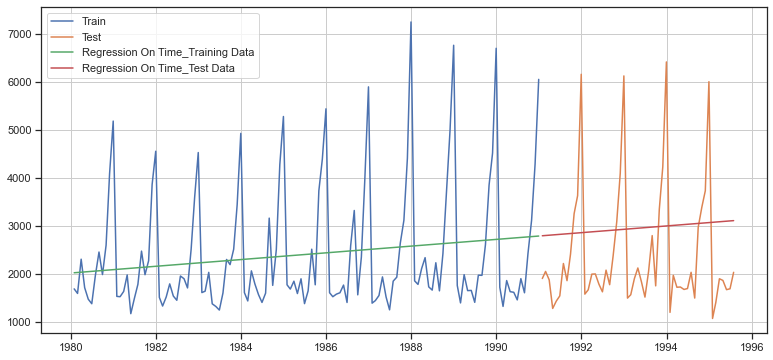

In [84]:
train_predictions_spark_lr = lr.predict(LinearRegression_train_spark[['time']])
LinearRegression_train_spark['RegOnTime'] = train_predictions_spark_lr

test_predictions_spark_lr = lr.predict(LinearRegression_test_spark[['time']])
LinearRegression_test_spark['RegOnTime'] = test_predictions_spark_lr

plt.figure(figsize=(13,6))
plt.plot( train_spark['Sparkling'], label='Train')
plt.plot(test_spark['Sparkling'], label='Test')
plt.plot(LinearRegression_train_spark['RegOnTime'], label='Regression On Time_Training Data')
plt.plot(LinearRegression_test_spark['RegOnTime'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

In [85]:
# Training Data - RMSE and MAPE

rmse_spark_train_lr = metrics.mean_squared_error(train_spark['Sparkling'],train_predictions_spark_lr,squared=False)
mape_spark_train_lr = MAPE(train_spark['Sparkling'],train_predictions_spark_lr)
print("For RegressionOnTime forecast on the Training Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_train_lr, mape_spark_train_lr))

For RegressionOnTime forecast on the Training Data,  RMSE is 1279.322 MAPE is 40.05


In [86]:
# Test Data - RMSE and MAPE

rmse_spark_test_lr = metrics.mean_squared_error(test_spark['Sparkling'],test_predictions_spark_lr,squared=False)
mape_spark_test_lr = MAPE(test_spark['Sparkling'],test_predictions_spark_lr)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_lr, mape_spark_test_lr))

For RegressionOnTime forecast on the Test Data,  RMSE is 1389.135 MAPE is 50.15


In [87]:
results_spark_lr = pd.DataFrame({'Test RMSE': [rmse_spark_test_lr],'Test MAPE': [mape_spark_test_lr]},index=['RegressionOnTime'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_lr])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56
RegressionOnTime,1389.135175,50.15


In [88]:
NaiveModel_train_spark = train_spark.copy()
NaiveModel_test_spark = test_spark.copy()

In [89]:
# Let us get the last value (or the most recent value) of the training set.

NaiveModel_train_spark['naive'] = np.asarray(train_spark['Sparkling'])[len(np.asarray(train_spark['Sparkling']))-1]
NaiveModel_train_spark['naive'].head()

YearMonth
1980-01-31    6047
1980-02-29    6047
1980-03-31    6047
1980-04-30    6047
1980-05-31    6047
Name: naive, dtype: int64

In [90]:
NaiveModel_test_spark['naive'] = np.asarray(train_spark['Sparkling'])[len(np.asarray(train_spark['Sparkling']))-1]
NaiveModel_test_spark['naive'].head()

YearMonth
1991-01-31    6047
1991-02-28    6047
1991-03-31    6047
1991-04-30    6047
1991-05-31    6047
Name: naive, dtype: int64

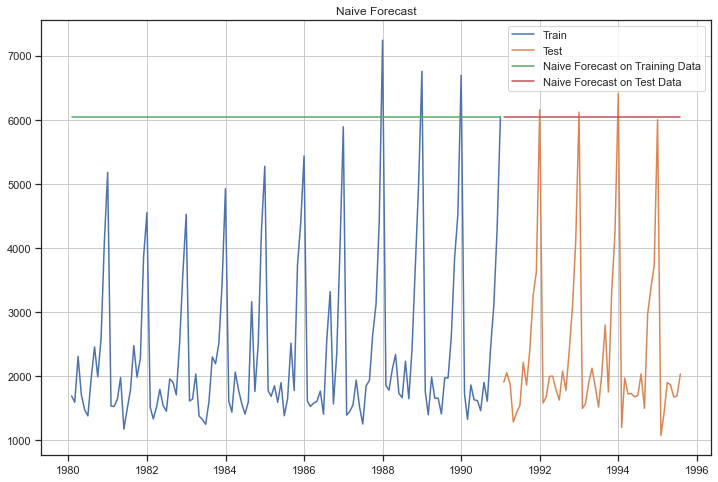

In [91]:
plt.figure(figsize=(12,8))
plt.plot(NaiveModel_train_spark['Sparkling'], label='Train')
plt.plot(test_spark['Sparkling'], label='Test')
plt.plot(NaiveModel_train_spark['naive'], label='Naive Forecast on Training Data')
plt.plot(NaiveModel_test_spark['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [92]:
# Training Data - RMSE and MAPE

rmse_spark_train_nv = metrics.mean_squared_error(train_spark['Sparkling'],NaiveModel_train_spark['naive'],squared=False)
mape_spark_train_nv = MAPE(train_spark['Sparkling'],NaiveModel_train_spark['naive'])
print("For Naive Model forecast on the Training Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_train_nv, mape_spark_train_nv))

For Naive Model forecast on the Training Data,  RMSE is 3867.701 MAPE is 153.17


In [93]:
# Test Data - RMSE and MAPE

rmse_spark_test_nv = metrics.mean_squared_error(test_spark['Sparkling'],NaiveModel_test_spark['naive'],squared=False)
mape_spark_test_nv = MAPE(test_spark['Sparkling'],NaiveModel_test_spark['naive'])
print("For Naive Model forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_nv, mape_spark_test_nv))

For Naive Model forecast on the Test Data,  RMSE is 3864.279 MAPE is 152.87


In [94]:
results_spark_nv = pd.DataFrame({'Test RMSE': [rmse_spark_test_nv],'Test MAPE': [mape_spark_test_nv]},index=['NaiveModel'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_nv])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56
RegressionOnTime,1389.135175,50.15
NaiveModel,3864.279352,152.87


In [95]:
SimpleAverage_train_spark = train_spark.copy()
SimpleAverage_test_spark = test_spark.copy()

In [96]:
# Let us get the last value (or the most recent value) of the training set.

SimpleAverage_train_spark['mean_forecast'] = train_spark['Sparkling'].mean()
SimpleAverage_train_spark.head()

,Sparkling,mean_forecast
YearMonth,,
1980-01-31,1686,2403.780303
1980-02-29,1591,2403.780303
1980-03-31,2304,2403.780303
1980-04-30,1712,2403.780303
1980-05-31,1471,2403.780303


In [97]:
SimpleAverage_test_spark['mean_forecast'] = train_spark['Sparkling'].mean()
SimpleAverage_test_spark.head()

,Sparkling,mean_forecast
YearMonth,,
1991-01-31,1902,2403.780303
1991-02-28,2049,2403.780303
1991-03-31,1874,2403.780303
1991-04-30,1279,2403.780303
1991-05-31,1432,2403.780303


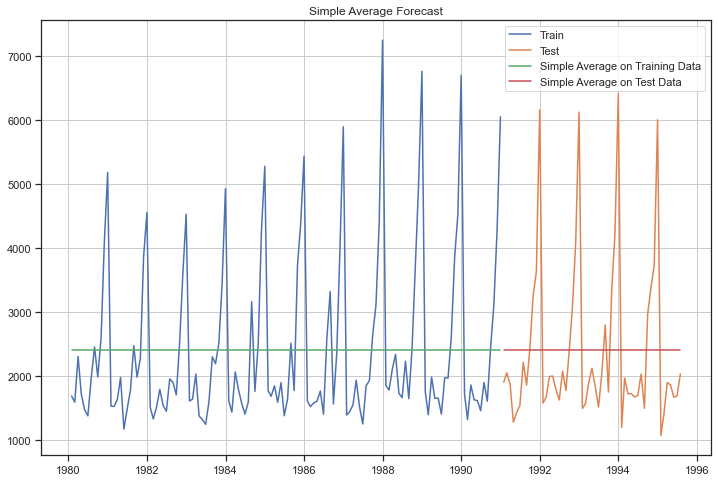

In [98]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAverage_train_spark['Sparkling'], label='Train')
plt.plot(SimpleAverage_test_spark['Sparkling'], label='Test')
plt.plot(SimpleAverage_train_spark['mean_forecast'], label='Simple Average on Training Data')
plt.plot(SimpleAverage_test_spark['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [99]:
# Training Data - RMSE and MAPE

rmse_spark_train_sa = metrics.mean_squared_error(train_spark['Sparkling'],SimpleAverage_train_spark['mean_forecast'],squared=False)
mape_spark_train_sa = MAPE(train_spark['Sparkling'],SimpleAverage_train_spark['mean_forecast'])
print("For Simple Average Model forecast on the Training Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_train_sa, mape_spark_train_sa))

For Simple Average Model forecast on the Training Data,  RMSE is 1298.484 MAPE is 40.36


In [100]:
# Test Data - RMSE and MAPE

rmse_spark_test_sa = metrics.mean_squared_error(test_spark['Sparkling'],SimpleAverage_test_spark['mean_forecast'],squared=False)
mape_spark_test_sa = MAPE(test_spark['Sparkling'],SimpleAverage_test_spark['mean_forecast'])
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_sa, mape_spark_test_sa))

For Simple Average forecast on the Test Data,  RMSE is 1275.082 MAPE is 38.90


In [101]:
results_spark_sa = pd.DataFrame({'Test RMSE': [rmse_spark_test_sa],'Test MAPE': [mape_spark_test_sa]} ,index=['SimpleAverageModel'])

resultsDf_spark = pd.concat([resultsDf_spark, results_spark_sa])
resultsDf_spark

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56
RegressionOnTime,1389.135175,50.15
NaiveModel,3864.279352,152.87
SimpleAverageModel,1275.081804,38.90


In [102]:
MovingAverage_spark = spark.copy()
MovingAverage_spark.head()

,Sparkling
YearMonth,
1980-01-31,1686
1980-02-29,1591
1980-03-31,2304
1980-04-30,1712
1980-05-31,1471


In [103]:
MovingAverage_spark['Trailing_2'] = MovingAverage_spark['Sparkling'].rolling(2).mean()
MovingAverage_spark['Trailing_4'] = MovingAverage_spark['Sparkling'].rolling(4).mean()
MovingAverage_spark['Trailing_6'] = MovingAverage_spark['Sparkling'].rolling(6).mean()
MovingAverage_spark['Trailing_9'] = MovingAverage_spark['Sparkling'].rolling(9).mean()

MovingAverage_spark.head()

,Sparkling,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-31,1686,NaN,NaN,NaN,NaN
1980-02-29,1591,1638.5,NaN,NaN,NaN
1980-03-31,2304,1947.5,NaN,NaN,NaN
1980-04-30,1712,2008.0,1823.25,NaN,NaN
1980-05-31,1471,1591.5,1769.50,NaN,NaN


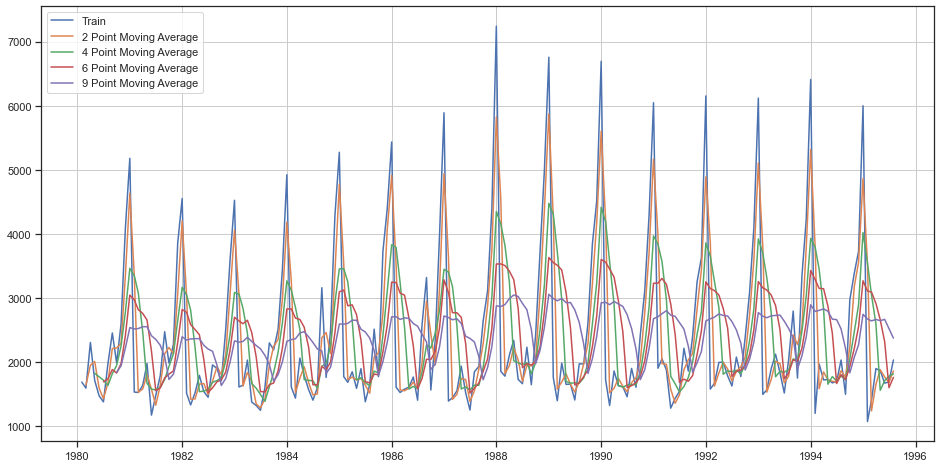

In [104]:
# Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(MovingAverage_spark['Sparkling'],label='Train')
plt.plot(MovingAverage_spark['Trailing_2'],label='2 Point Moving Average')
plt.plot(MovingAverage_spark['Trailing_4'],label='4 Point Moving Average')
plt.plot(MovingAverage_spark['Trailing_6'],label='6 Point Moving Average')
plt.plot(MovingAverage_spark['Trailing_9'],label='9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [105]:
#Creating train and test set 
trailing_MovingAverage_train_spark=MovingAverage_spark[MovingAverage_spark.index < '1991-01-01'] 
trailing_MovingAverage_test_spark=MovingAverage_spark[MovingAverage_spark.index >= '1991-01-01']

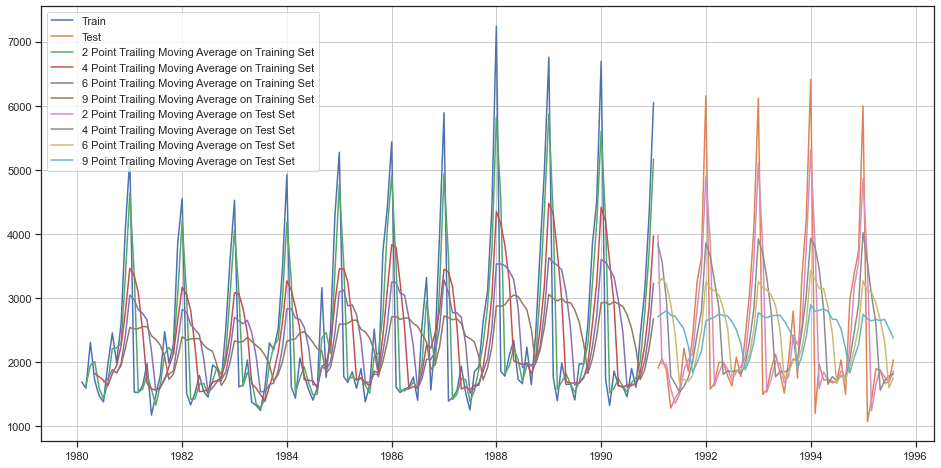

In [106]:
# Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train_spark['Sparkling'],label='Train')
plt.plot(trailing_MovingAverage_test_spark['Sparkling'],label='Test')

plt.plot(trailing_MovingAverage_train_spark['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_spark['Trailing_4'],label='4 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_spark['Trailing_6'],label ='6 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_train_spark['Trailing_9'],label ='9 Point Trailing Moving Average on Training Set')

plt.plot(trailing_MovingAverage_test_spark['Trailing_2'],label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_spark['Trailing_4'],label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_spark['Trailing_6'],label='6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test_spark['Trailing_9'],label='9 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [107]:
# Test Data - RMSE and MAPE --> 2 point Trailing MA

rmse_spark_test_2_ma = metrics.mean_squared_error(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_2'],squared=False)
mape_spark_test_2_ma = MAPE(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_2'])
print("For 2 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_2_ma, mape_spark_test_2_ma))

# Test Data - RMSE and MAPE --> 4 point Trailing MA

rmse_spark_test_4_ma = metrics.mean_squared_error(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_4'],squared=False)
mape_spark_test_4_ma = MAPE(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_4'])
print("For 4 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_4_ma, mape_spark_test_4_ma))

# Test Data - RMSE and MAPE --> 6 point Trailing MA

rmse_spark_test_6_ma = metrics.mean_squared_error(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_6'],squared=False)
mape_spark_test_6_ma = MAPE(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_6'])
print("For 6 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_6_ma, mape_spark_test_6_ma))

# Test Data - RMSE and MAPE --> 9 point Trailing MA

rmse_spark_test_9_ma = metrics.mean_squared_error(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_9'],squared=False)
mape_spark_test_9_ma = MAPE(test_spark['Sparkling'],trailing_MovingAverage_test_spark['Trailing_9'])
print("For 9 point Moving Average Model forecast on the Test Data,  RMSE is %3.3f MAPE is %3.2f" %(rmse_spark_test_9_ma, mape_spark_test_9_ma))

For 2 point Moving Average Model forecast on the Test Data,  RMSE is 813.401 MAPE is 19.70
For 4 point Moving Average Model forecast on the Test Data,  RMSE is 1156.590 MAPE is 35.96
For 6 point Moving Average Model forecast on the Test Data,  RMSE is 1283.927 MAPE is 43.86
For 9 point Moving Average Model forecast on the Test Data,  RMSE is 1346.278 MAPE is 46.86


In [108]:
results_spark_ma = pd.DataFrame({'Test RMSE': [rmse_spark_test_2_ma,rmse_spark_test_4_ma
                                          ,rmse_spark_test_6_ma,rmse_spark_test_9_ma]
                            ,'Test MAPE': [mape_spark_test_2_ma,mape_spark_test_4_ma,mape_spark_test_6_ma
                                           ,mape_spark_test_9_ma]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

results_spark_Smoothing = pd.concat([resultsDf_spark, results_spark_ma])
results_spark_Smoothing

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56
RegressionOnTime,1389.135175,50.15
NaiveModel,3864.279352,152.87
SimpleAverageModel,1275.081804,38.90
2pointTrailingMovingAverage,813.400684,19.70
4pointTrailingMovingAverage,1156.589694,35.96


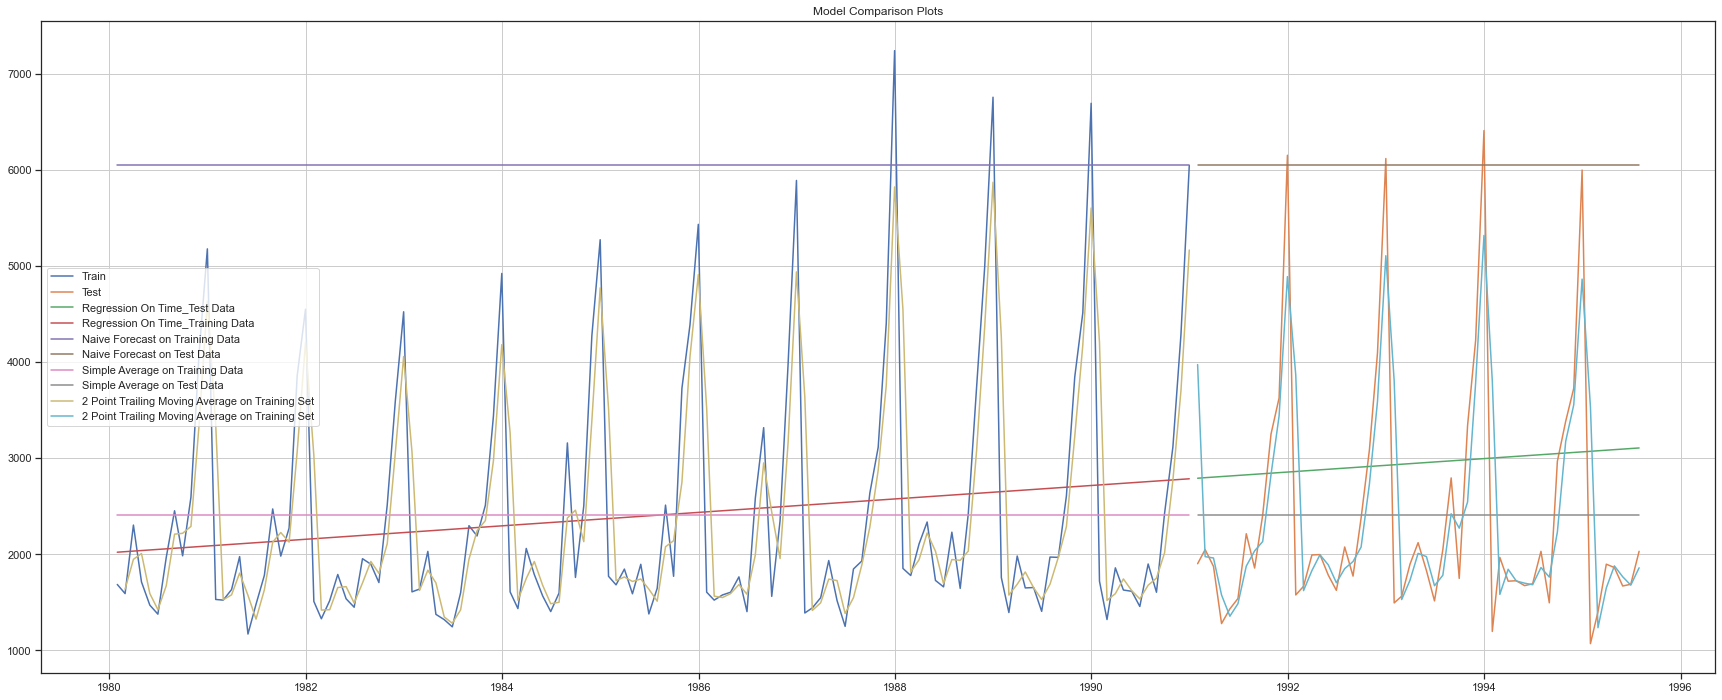

In [109]:
# Plotting on both Training and Test data

plt.figure(figsize=(30,12))
plt.plot(train_spark['Sparkling'],label='Train')
plt.plot(test_spark['Sparkling'],label='Test')

plt.plot(LinearRegression_test_spark['RegOnTime'],label='Regression On Time_Test Data')
plt.plot(LinearRegression_train_spark['RegOnTime'],label='Regression On Time_Training Data')

plt.plot(NaiveModel_train_spark['naive'],label='Naive Forecast on Training Data')
plt.plot(NaiveModel_test_spark['naive'],label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_train_spark['mean_forecast'],label='Simple Average on Training Data')
plt.plot(SimpleAverage_test_spark['mean_forecast'],label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_train_spark['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_MovingAverage_test_spark['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')

plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

In [110]:
#Q5
# Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity_spark(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

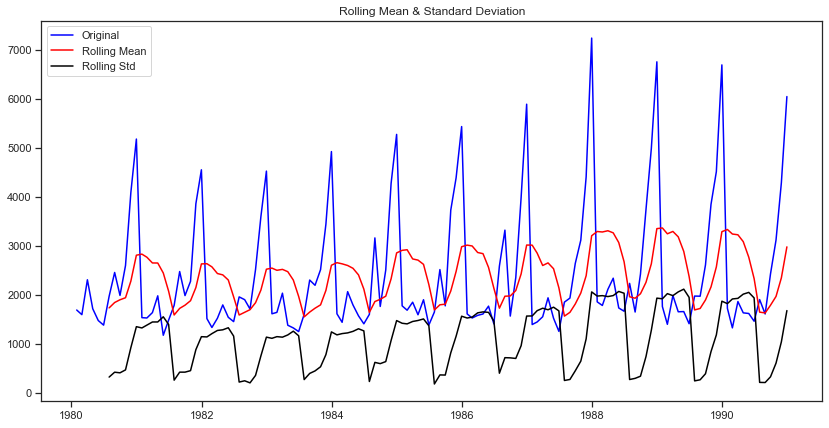

Results of Dickey-Fuller Test:
Test Statistic                  -1.208926
p-value                          0.669744
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64 



In [111]:
test_stationarity_spark(train_spark['Sparkling'])

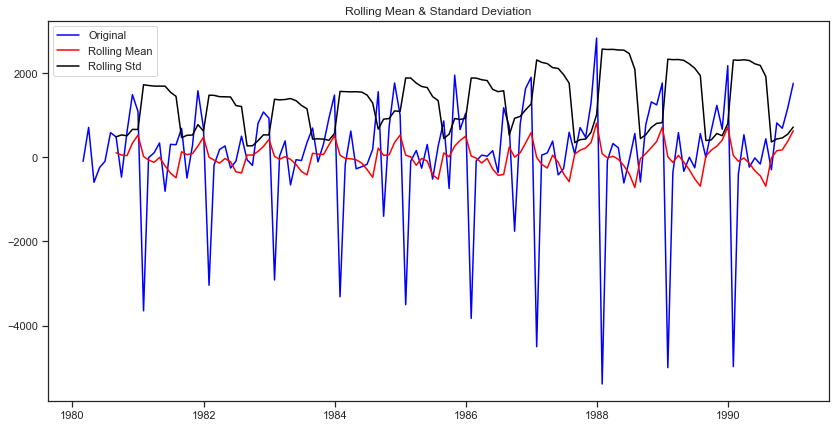

Results of Dickey-Fuller Test:
Test Statistic                -8.005007e+00
p-value                        2.280104e-12
#Lags Used                     1.100000e+01
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64 



In [112]:
#We see that at 5% significant level the Time Series is non-stationary
#Let us take a difference of order 1 and check whether the Time Series is stationary or not
test_stationarity_spark(train_spark['Sparkling'].diff().dropna())

In [113]:
train_spark.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 1980-01-31 to 1990-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  132 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


In [114]:
#Q6
import itertools
p = q = range(0, 3)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [115]:
# Creating an empty Dataframe with column names only
ARIMA_AIC_spark = pd.DataFrame(columns=['param', 'AIC'])

In [116]:
from statsmodels.tsa.arima_model import ARIMA

for param in pdq:
    ARIMA_model_spark = ARIMA(train_spark['Sparkling'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model_spark.aic))
    ARIMA_AIC_spark = ARIMA_AIC_spark.append({'param':param, 'AIC': ARIMA_model_spark.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:2269.582796371201
ARIMA(0, 1, 1) - AIC:2264.90643899768
ARIMA(0, 1, 2) - AIC:2232.783097685749
ARIMA(1, 1, 0) - AIC:2268.5280613021696
ARIMA(1, 1, 1) - AIC:2235.013945351209
ARIMA(1, 1, 2) - AIC:2233.597647118897
ARIMA(2, 1, 0) - AIC:2262.035600260619
ARIMA(2, 1, 1) - AIC:2232.36048987896
ARIMA(2, 1, 2) - AIC:2210.6213693964587


In [117]:
# Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value
ARIMA_AIC_spark.sort_values(by='AIC',ascending=True)

,param,AIC
8,"(2, 1, 2)",2210.621369
7,"(2, 1, 1)",2232.360490
2,"(0, 1, 2)",2232.783098
5,"(1, 1, 2)",2233.597647
4,"(1, 1, 1)",2235.013945
6,"(2, 1, 0)",2262.035600
1,"(0, 1, 1)",2264.906439
3,"(1, 1, 0)",2268.528061
0,"(0, 1, 0)",2269.582796


In [118]:
mod_Arima_spark = ARIMA(train_spark['Sparkling'], order=(2,1,2),freq='M')
results_Arima_spark = mod_Arima_spark.fit()
print(results_Arima_spark.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  131
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1099.311
Method:                       css-mle   S.D. of innovations           1013.283
Date:                Fri, 24 Jul 2020   AIC                           2210.621
Time:                        18:17:24   BIC                           2227.873
Sample:                    02-29-1980   HQIC                          2217.631
                         - 12-31-1990                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.5852      0.518     10.789      0.000       4.571       6.600
ar.L1.D.Sparkling     1.2699      0.075     17.043      0.000       1.124       1.416
ar.L2.D.Sparkling    -0.

In [119]:
predicted_Arima_spark = results_Arima_spark.forecast(steps=len(test_spark))

In [120]:
from sklearn.metrics import  mean_squared_error
rmse_Arima_spark = mean_squared_error(test_spark['Sparkling'],predicted_Arima_spark[0],squared=False)
print(rmse_Arima_spark)

1374.2974106208414


In [121]:
results_Arima_spark = pd.DataFrame({'Test RMSE': [rmse_Arima_spark]},index=['ARIMA(2,1,2)'])
results_Arima_spark

,Test RMSE
"ARIMA(2,1,2)",1374.297411


In [122]:
mod_Arima_spark_full = ARIMA(spark['Sparkling'], order=(2,1,2),freq='M')
results_Arima_spark_full = mod_Arima_spark_full.fit()
print(results_Arima_spark_full.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  186
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1572.156
Method:                       css-mle   S.D. of innovations           1110.608
Date:                Fri, 24 Jul 2020   AIC                           3156.313
Time:                        18:17:26   BIC                           3175.667
Sample:                    02-29-1980   HQIC                          3164.156
                         - 07-31-1995                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.2957      0.694      3.310      0.001       0.936       3.655
ar.L1.D.Sparkling     1.1903      0.068     17.545      0.000       1.057       1.323
ar.L2.D.Sparkling    -0.

In [123]:
# Forecast for next 12 months
predicted_Arima_spark_full = results_Arima_spark_full.predict(start='1995-08-01',end='1996-07-01',typ='levels')

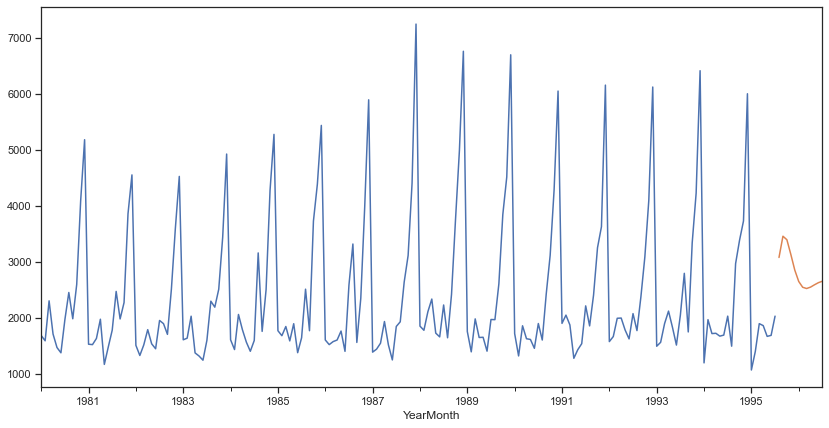

In [124]:
#Q9-Plotting the actual Time Series and the forecasted Time Series
spark['Sparkling'].plot()
predicted_Arima_spark_full.plot();

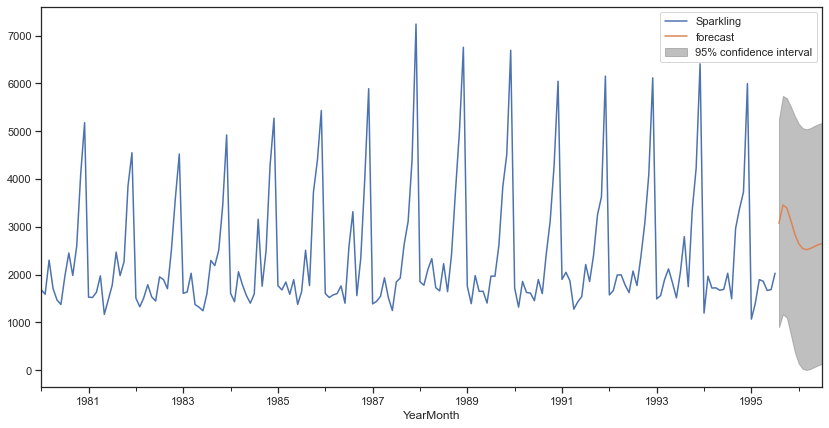

In [125]:
#Q9-Plotting the acutal Time Series with the confidence interval

fig, ax = plt.subplots()
ax = spark['Sparkling'].plot(ax=ax)
fig = results_Arima_spark_full.plot_predict(start='1995-08-01',end='1996-07-01',dynamic=True,plot_insample=False,alpha=0.05,ax=ax);

In [126]:
#SARIMA
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], model_pdq[i]))

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)


In [127]:
SARIMA_AIC_spark = pd.DataFrame(columns=['param','seasonal', 'AIC'])

In [128]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model_spark = sm.tsa.statespace.SARIMAX(train_spark['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA_spark = SARIMA_model_spark.fit(maxiter=1000)
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA_spark.aic))
        SARIMA_AIC_spark = SARIMA_AIC_spark.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA_spark.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12)7 - AIC:2251.3597196862966
SARIMA(0, 1, 0)x(0, 0, 1, 12)7 - AIC:1956.26146168447
SARIMA(0, 1, 0)x(0, 0, 2, 12)7 - AIC:1723.1533640234122
SARIMA(0, 1, 0)x(1, 0, 0, 12)7 - AIC:1837.4366022456675
SARIMA(0, 1, 0)x(1, 0, 1, 12)7 - AIC:1806.9905301389326
SARIMA(0, 1, 0)x(1, 0, 2, 12)7 - AIC:1633.21087357917
SARIMA(0, 1, 0)x(2, 0, 0, 12)7 - AIC:1648.3776153470858
SARIMA(0, 1, 0)x(2, 0, 1, 12)7 - AIC:1647.2054158603798
SARIMA(0, 1, 0)x(2, 0, 2, 12)7 - AIC:1630.9898053920829
SARIMA(0, 1, 1)x(0, 0, 0, 12)7 - AIC:2230.162907850583
SARIMA(0, 1, 1)x(0, 0, 1, 12)7 - AIC:1923.7688649566423
SARIMA(0, 1, 1)x(0, 0, 2, 12)7 - AIC:1692.7089572820646
SARIMA(0, 1, 1)x(1, 0, 0, 12)7 - AIC:1797.179588183797
SARIMA(0, 1, 1)x(1, 0, 1, 12)7 - AIC:1738.0903193753004
SARIMA(0, 1, 1)x(1, 0, 2, 12)7 - AIC:1570.150914452287
SARIMA(0, 1, 1)x(2, 0, 0, 12)7 - AIC:1605.6751954178073
SARIMA(0, 1, 1)x(2, 0, 1, 12)7 - AIC:1599.224508418928
SARIMA(0, 1, 1)x(2, 0, 2, 12)7 - AIC:1570.4018824113045


In [129]:
SARIMA_AIC_spark.sort_values(by=['AIC']).head()

,param,seasonal,AIC
50,"(1, 1, 2)","(1, 0, 2, 12)",1555.584247
53,"(1, 1, 2)","(2, 0, 2, 12)",1555.934564
26,"(0, 1, 2)","(2, 0, 2, 12)",1557.121563
23,"(0, 1, 2)","(1, 0, 2, 12)",1557.160507
77,"(2, 1, 2)","(1, 0, 2, 12)",1557.340405


In [130]:
import statsmodels.api as sm

mod_SARIMA_spark = sm.tsa.statespace.SARIMAX(train_spark['Sparkling'].values,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA_spark = mod_SARIMA_spark.fit(maxiter=1000)
print(results_SARIMA_spark.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood                -770.792
Date:                            Fri, 24 Jul 2020   AIC                           1555.584
Time:                                    18:22:27   BIC                           1574.095
Sample:                                         0   HQIC                          1563.083
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6282      0.255     -2.464      0.014      -1.128      -0.128
ma.L1         -0.1040      0.225   

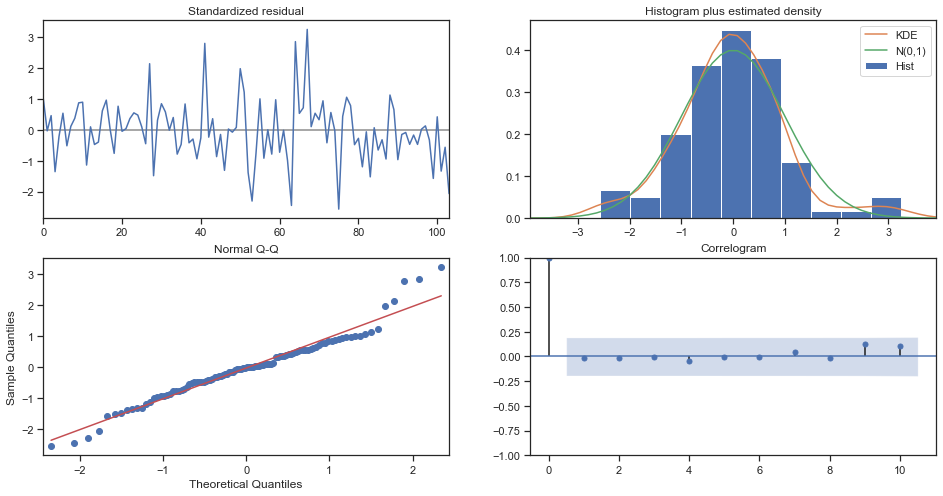

In [131]:
results_SARIMA_spark.plot_diagnostics(figsize=(16, 8))
plt.show()

In [132]:
pred_SARIMA_spark = results_SARIMA_spark.get_forecast(steps=len(test_spark))
pred_SARIMA_spark.predicted_mean

array([1327.34052983, 1315.0714994 , 1621.53522406, 1598.82623116,
       1392.64113282, 1224.77641044, 1780.39011593, 1787.78726666,
       2192.49857384, 3184.28552976, 4490.59390172, 6525.00137088,
       1307.17633098, 1172.6893179 , 1572.06883381, 1504.36602349,
       1306.72590199, 1095.88390493, 1716.91746846, 1784.46364876,
       2126.28176697, 3224.63228645, 4587.02063702, 6765.67946149,
       1251.45164682, 1074.57600454, 1514.40207645, 1429.32963693,
       1232.06171529, 1006.28540259, 1658.1408244 , 1726.40881003,
       2084.63530441, 3230.29920374, 4653.02826387, 6926.94264412,
       1170.95672405,  986.18155919, 1445.39481098, 1356.53481165,
       1150.64446337,  914.93908882, 1595.41296085, 1666.66824018,
       2040.61988679, 3236.55490735, 4721.71880952, 7095.41665474,
       1086.8451794 ,  893.96111942, 1373.32607032, 1280.56647702,
       1065.64129845,  819.59252913, 1529.92726774])

In [133]:
pred_SARIMA_spark.summary_frame(alpha=0.05)

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,1327.340530,388.343220,566.201805,2088.479254
1,1315.071499,402.008107,527.150088,2102.992911
2,1621.535224,402.001720,833.626330,2409.444118
3,1598.826231,407.241037,800.648467,2397.003996
4,1392.641133,407.971444,593.031797,2192.250469
5,1224.776410,411.025884,419.180481,2030.372340
6,1780.390116,412.424097,972.053740,2588.726492
7,1787.787267,414.768657,974.855638,2600.718895
8,2192.498574,416.477698,1376.217285,3008.779862
9,3184.285530,418.558245,2363.926444,4004.644615


In [134]:
rmse_SARIMA_spark = mean_squared_error(test_spark['Sparkling'],pred_SARIMA_spark.predicted_mean,squared=False)
print(rmse_SARIMA_spark)

528.6553374467247


In [135]:
results_SARIMA_spark = pd.DataFrame({'Test RMSE': [rmse_SARIMA_spark]}
                           ,index=['SARIMA(1, 1, 2)(1, 0, 2, 12)'])

resultsDf_spark1 = pd.concat([results_Arima_spark,results_SARIMA_spark])

resultsDf_spark1

,Test RMSE
"ARIMA(2,1,2)",1374.297411
"SARIMA(1, 1, 2)(1, 0, 2, 12)",528.655337


In [136]:
mod_SARIMA_spark_full = sm.tsa.statespace.SARIMAX(spark['Sparkling'], freq='M',
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_SARIMA_spark_full = mod_SARIMA_spark_full.fit(maxiter=1000)
print(results_SARIMA_spark_full.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  187
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1173.413
Date:                            Fri, 24 Jul 2020   AIC                           2360.826
Time:                                    18:22:44   BIC                           2382.308
Sample:                                01-31-1980   HQIC                          2369.549
                                     - 07-31-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6610      0.242     -2.733      0.006      -1.135      -0.187
ma.L1         -0.1801      0.219   

In [137]:
pred_SARIMA_spark_full_date = results_SARIMA_spark_full.get_forecast(steps=12)

In [138]:
pred_SARIMA_spark_full_date = pd.DataFrame(pred_SARIMA_spark_full_date.summary_frame())
pred_SARIMA_spark_full_date

Sparkling,mean,mean_se,mean_ci_lower,mean_ci_upper
1995-08-31,1836.394117,379.710923,1092.174383,2580.613851
1995-09-30,2489.561197,384.474497,1736.005030,3243.117364
1995-10-31,3324.577367,384.580204,2570.814019,4078.340716
1995-11-30,4020.221318,386.338461,3263.011850,4777.430787
1995-12-31,6289.984371,386.393045,5532.667919,7047.300823
1996-01-31,1244.698679,387.303521,485.597726,2003.799633
1996-02-29,1533.160477,387.531938,773.611835,2292.709119
1996-03-31,1821.698353,388.159071,1060.920554,2582.476152
1996-04-30,1788.494087,388.499189,1027.049668,2549.938506
1996-05-31,1627.572182,389.018381,865.110166,2390.034197


In [139]:
# Forecast for next 12 months
predicted_SARIMA_spark_full = results_SARIMA_spark_full.predict(start='1995-08-01',end='1996-07-01',typ='levels')

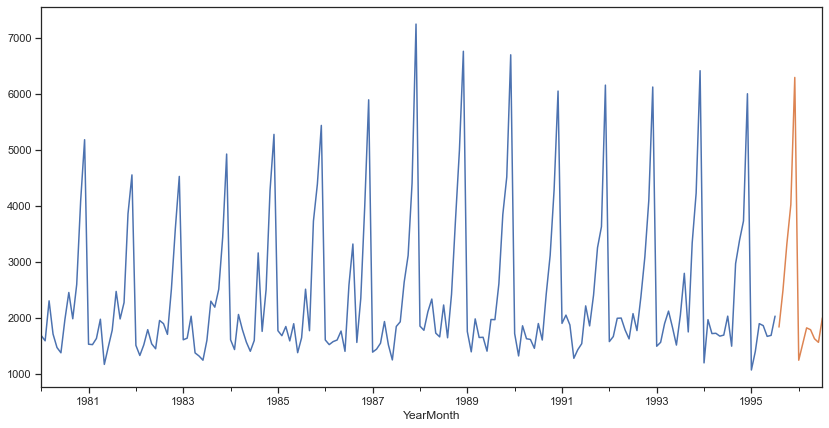

In [140]:
#Q9-Plotting the actual Time Series and the forecasted Time Series
spark['Sparkling'].plot()
predicted_SARIMA_spark_full.plot();

In [141]:
pred_dynamic_SARIMA_spark_full = results_SARIMA_spark_full.get_prediction(start=pd.to_datetime('1995-08-01'), dynamic=True, full_results=True)

In [142]:
pred_dynamic_ci_SARIMA_spark_full = pred_dynamic_SARIMA_spark_full.conf_int()

In [143]:
pred95_SARIMA_spark_full = results_SARIMA_spark_full.get_forecast(steps=12, alpha=0.05)
pred_ci_95_SARIMA_spark_full = pred95_SARIMA_spark_full.conf_int()

In [144]:
forecast_fullmodel_autosarima_SARIMA_spark_full = pred95_SARIMA_spark_full.predicted_mean

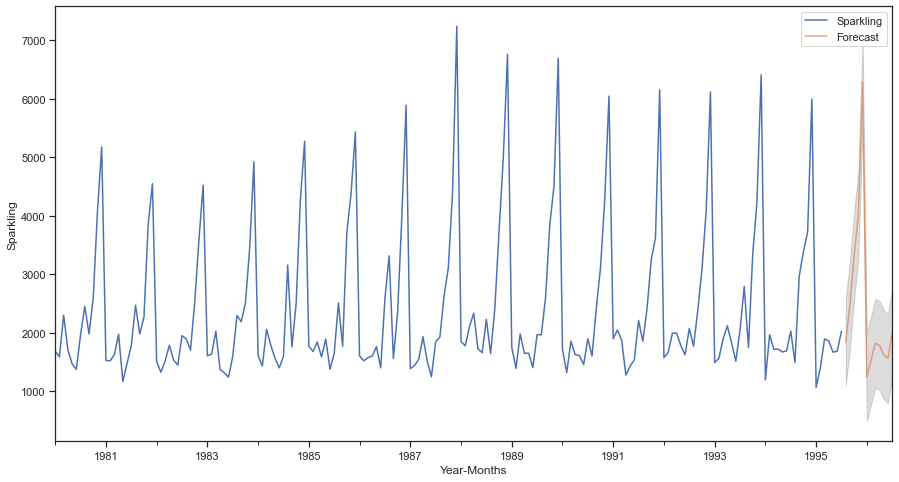

In [145]:
#Q9- plot the forecast along with the confidence band

axis = spark.plot(label='Observed', figsize=(15, 8))
forecast_fullmodel_autosarima_SARIMA_spark_full.plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(forecast_fullmodel_autosarima_SARIMA_spark_full.index, pred_ci_95_SARIMA_spark_full['lower Sparkling'], pred_ci_95_SARIMA_spark_full['upper Sparkling'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling')
plt.legend(loc='best')
plt.show()

In [146]:
#Q7
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

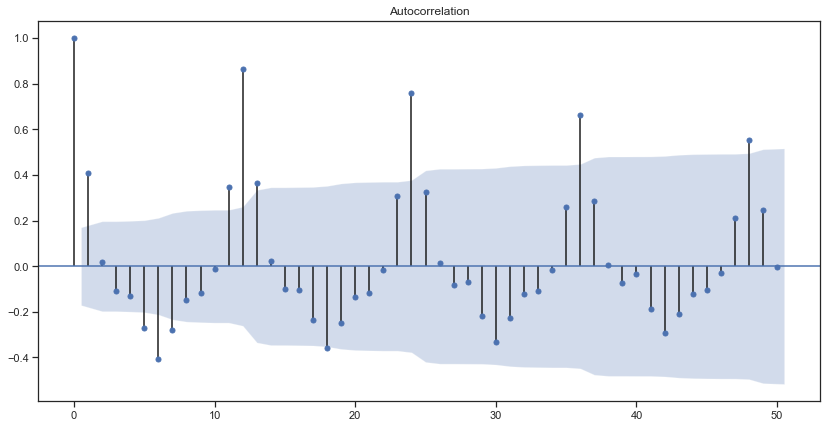

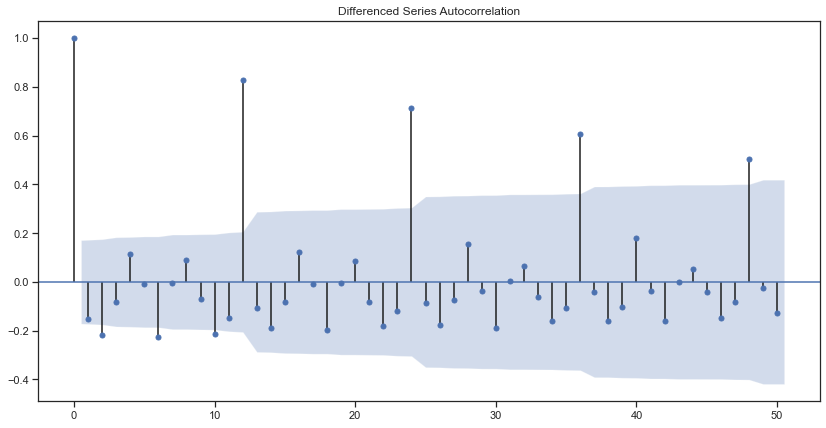

In [147]:
plot_acf(train_spark['Sparkling'],lags=50)
plot_acf(train_spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Series Autocorrelation')
plt.show()

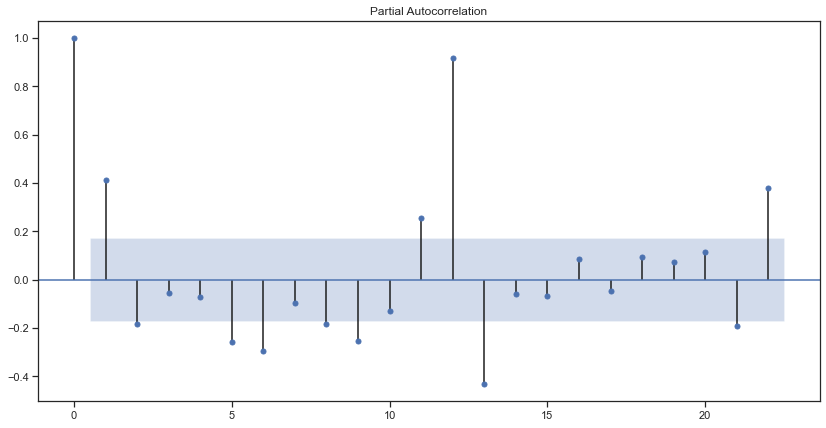

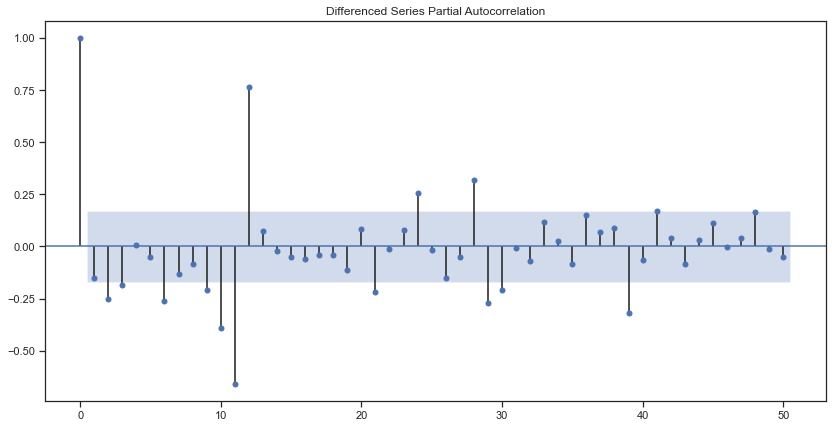

In [148]:
plot_pacf(train_spark['Sparkling'])
plot_pacf(train_spark['Sparkling'].diff().dropna(),lags=50,title='Differenced Series Partial Autocorrelation')
plt.show()

In [149]:
mod_ARIMA_spark_cf = ARIMA(train_spark['Sparkling'].values, order=(1, 1, 1))
results_ARIMA_spark_cf = mod_ARIMA_spark_cf.fit(maxiter=1000)
print(results_ARIMA_spark_cf.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1113.507
Method:                       css-mle   S.D. of innovations           1171.378
Date:                Fri, 24 Jul 2020   AIC                           2235.014
Time:                        18:22:48   BIC                           2246.515
Sample:                             1   HQIC                          2239.687
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7489      4.616      1.462      0.144      -2.299      15.797
ar.L1.D.y      0.4289      0.082      5.221      0.000       0.268       0.590
ma.L1.D.y     -1.0000      0.019    -51.962      0.0

In [150]:
predicted_ARIMA_spark_cf = results_ARIMA_spark_cf.forecast(steps=len(test_spark))

In [151]:
rmse_ARIMA_spark_cf = mean_squared_error(test_spark['Sparkling'],predicted_ARIMA_spark_cf[0],squared=False)
print(rmse_ARIMA_spark_cf)

1461.6626025674825


In [152]:
results_ARIMA_spark_cf = pd.DataFrame({'Test RMSE': [rmse_ARIMA_spark_cf]}
                           ,index=['ARIMA_CF(1, 1, 1)'])


resultsDf_spark1 = pd.concat([resultsDf_spark1,results_ARIMA_spark_cf])

resultsDf_spark1

,Test RMSE
"ARIMA(2,1,2)",1374.297411
"SARIMA(1, 1, 2)(1, 0, 2, 12)",528.655337
"ARIMA_CF(1, 1, 1)",1461.662603


In [153]:
mod_ARIMA_spark_full_cf = ARIMA(spark['Sparkling'], order=(1, 1, 1),freq='M')
results_ARIMA_spark_full_cf = mod_ARIMA_spark_full_cf.fit()
print(results_ARIMA_spark_full_cf.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  186
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1585.295
Method:                       css-mle   S.D. of innovations           1202.511
Date:                Fri, 24 Jul 2020   AIC                           3178.590
Time:                        18:22:49   BIC                           3191.493
Sample:                    02-29-1980   HQIC                          3183.819
                         - 07-31-1995                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.0785      2.554      0.814      0.416      -2.928       7.085
ar.L1.D.Sparkling     0.3681      0.069      5.370      0.000       0.234       0.503
ma.L1.D.Sparkling    -1.

In [154]:
# Forecast for next 12 months
predicted_ARIMA_spark_full_cf = results_ARIMA_spark_full_cf.predict(start='1995-08-01',end='1996-07-01',typ='levels')

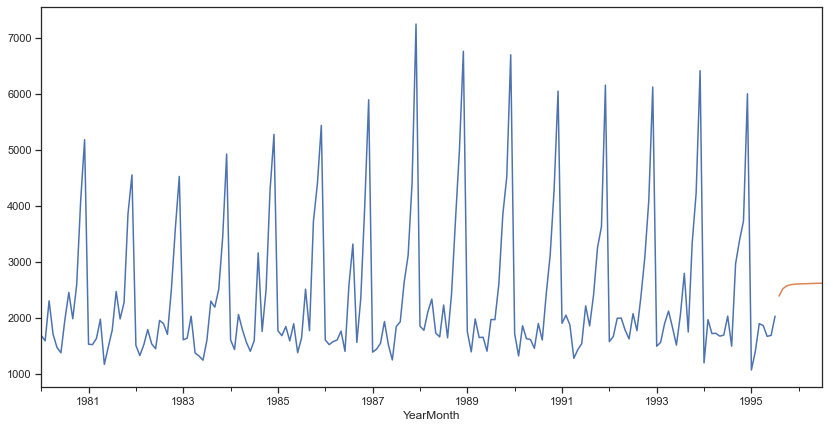

In [155]:
#Q9-Plotting the actual Time Series and the forecasted Time Series
spark['Sparkling'].plot()
predicted_ARIMA_spark_full_cf.plot();

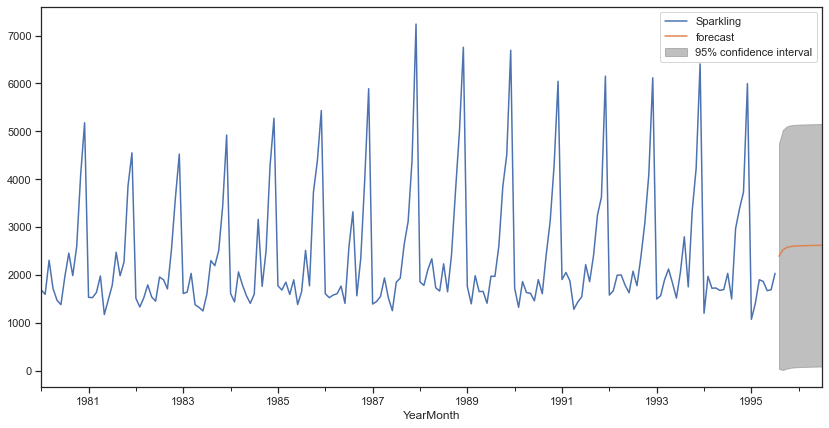

In [156]:
#Q9-Plotting the acutal Time Series with the confidence interval

fig, ax = plt.subplots()
ax = spark['Sparkling'].plot(ax=ax)
fig = results_ARIMA_spark_full_cf.plot_predict(start='1995-08-01',end='1996-07-01',dynamic=True,plot_insample=False,alpha=0.05,ax=ax);

In [157]:
mod_SARIMA_spark_cf = sm.tsa.statespace.SARIMAX(train_spark['Sparkling'], freq='M',
                                order=(1, 1, 1),
                                seasonal_order=(2, 0, 7, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_SARIMA_spark_cf = mod_SARIMA_spark_cf.fit(maxiter=1000)
print(results_SARIMA_spark_cf.summary())

                                               SARIMAX Results                                                
Dep. Variable:                                              Sparkling   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2, 3, 4, 5, 6, 7], 12)   Log Likelihood                -342.505
Date:                                                Fri, 24 Jul 2020   AIC                            709.010
Time:                                                        18:24:50   BIC                            730.690
Sample:                                                    01-31-1980   HQIC                           717.092
                                                         - 12-31-1990                                         
Covariance Type:                                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

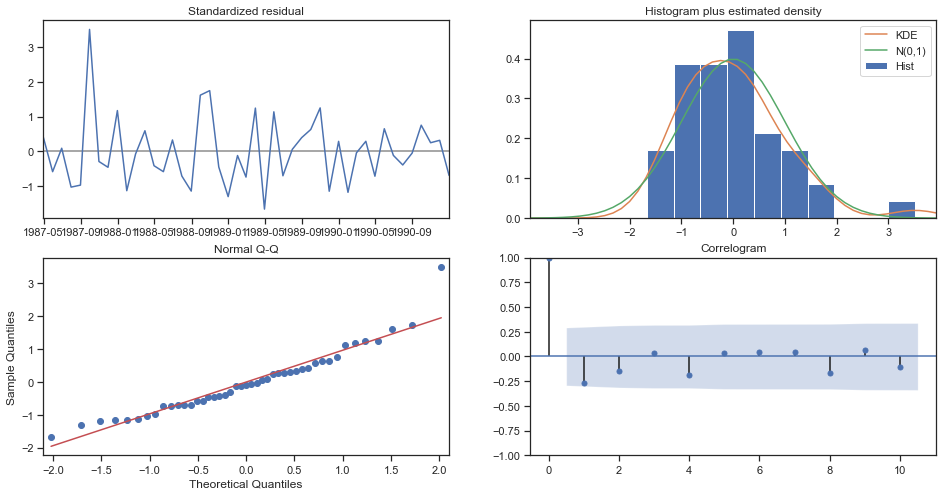

In [158]:
results_SARIMA_spark_cf.plot_diagnostics(figsize=(16, 8))
plt.show()

In [159]:
pred_SARIMA_spark_cf = results_SARIMA_spark_cf.get_forecast(steps=len(test_spark))
pred_SARIMA_spark_cf.predicted_mean

1991-01-31    1715.025773
1991-02-28    1608.897474
1991-03-31    2017.289569
1991-04-30    1991.172720
1991-05-31    1646.257965
1991-06-30    1576.359468
1991-07-31    1745.886166
1991-08-31    1321.660311
1991-09-30    2652.477348
1991-10-31    3631.687917
1991-11-30    4274.744752
1991-12-31    5960.351746
1992-01-31    1861.639704
1992-02-29    1628.037300
1992-03-31    2216.271241
1992-04-30    1827.243617
1992-05-31    1717.672755
1992-06-30    1647.920637
1992-07-31    1768.192391
1992-08-31    1429.366293
1992-09-30    2540.490558
1992-10-31    3781.593025
1992-11-30    4289.849357
1992-12-31    5471.940691
1993-01-31    1793.649092
1993-02-28    1516.515810
1993-03-31    2121.335444
1993-04-30    1624.599727
1993-05-31    1710.629218
1993-06-30    1600.749303
1993-07-31    1639.346039
1993-08-31    1490.083923
1993-09-30    2559.979332
1993-10-31    3615.533286
1993-11-30    4032.310336
1993-12-31    5196.741516
1994-01-31    1834.560161
1994-02-28    1643.094810
1994-03-31  

In [160]:
rmse_SARIMA_spark_cf = mean_squared_error(test_spark['Sparkling'],pred_SARIMA_spark_cf.predicted_mean,squared=False)
print(rmse_SARIMA_spark_cf)

455.4986448256949


In [161]:
results_SARIMA_spark_cf = pd.DataFrame({'Test RMSE': [rmse_SARIMA_spark_cf]}
                           ,index=['SARIMA_CF(1, 1, 1)(2, 0, 7, 12)'])


results_spark_ARIMASARIMA = pd.concat([resultsDf_spark1,results_SARIMA_spark_cf])

results_spark_ARIMASARIMA

,Test RMSE
"ARIMA(2,1,2)",1374.297411
"SARIMA(1, 1, 2)(1, 0, 2, 12)",528.655337
"ARIMA_CF(1, 1, 1)",1461.662603
"SARIMA_CF(1, 1, 1)(2, 0, 7, 12)",455.498645


In [162]:
# Building the model on the whole data

mod_SARIMA_spark_full_cf = sm.tsa.statespace.SARIMAX(spark['Sparkling'], freq='M',
                                order=(1,1,1),
                                seasonal_order=(2, 0, 7, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA_spark_full_cf = mod_SARIMA_spark_full_cf.fit()
print(results_SARIMA_spark_full_cf.summary())

                                               SARIMAX Results                                                
Dep. Variable:                                              Sparkling   No. Observations:                  187
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2, 3, 4, 5, 6, 7], 12)   Log Likelihood                -756.831
Date:                                                Fri, 24 Jul 2020   AIC                           1537.663
Time:                                                        18:27:31   BIC                           1568.925
Sample:                                                    01-31-1980   HQIC                          1550.315
                                                         - 07-31-1995                                         
Covariance Type:                                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [163]:
pred_SARIMA_spark_full_cf_date = results_SARIMA_spark_full_cf.get_forecast(steps=12)

In [164]:
pred_SARIMA_spark_full_cf_date = pd.DataFrame(pred_SARIMA_spark_full_cf_date.summary_frame())
pred_SARIMA_spark_full_cf_date

Sparkling,mean,mean_se,mean_ci_lower,mean_ci_upper
1995-08-31,1886.178792,347.694718,1204.709667,2567.647917
1995-09-30,2340.042022,378.964561,1597.285132,3082.798913
1995-10-31,3335.016328,394.386560,2562.032874,4107.999782
1995-11-30,4053.950238,407.011077,3256.223186,4851.677291
1995-12-31,6240.184902,418.836570,5419.280309,7061.089495
1996-01-31,1689.716980,430.254105,846.434430,2532.999530
1996-02-29,2133.411419,441.348599,1268.384060,2998.438778
1996-03-31,1983.924119,452.160360,1097.706099,2870.142140
1996-04-30,1515.346064,462.716565,608.438261,2422.253867
1996-05-31,1525.959316,473.037996,598.821880,2453.096752


In [165]:
# Forecast for next 12 months
pred_SARIMA_spark_full_cf_date = results_SARIMA_spark_full_cf.predict(start='1995-08-01',end='1996-07-01',typ='levels')

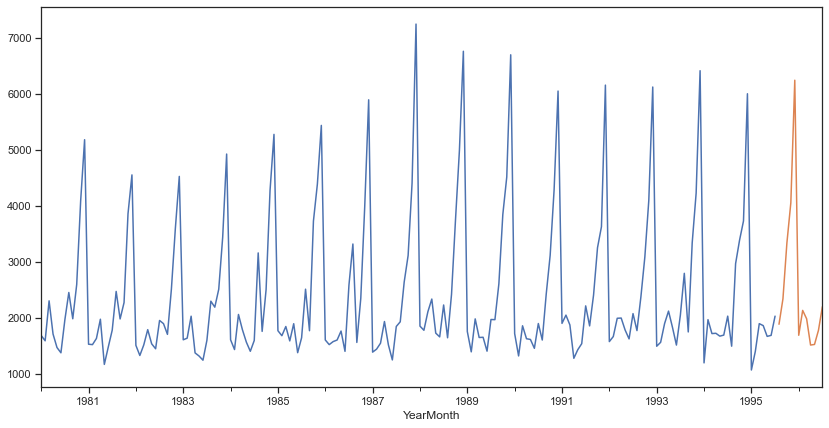

In [166]:
#Q9-Plotting the actual Time Series and the forecasted Time Series
spark['Sparkling'].plot()
pred_SARIMA_spark_full_cf_date.plot();

In [167]:
pred_dynamic_SARIMA_spark_full_cf = results_SARIMA_spark_full_cf.get_prediction(start=pd.to_datetime('1995-08-01'), dynamic=True, full_results=True)

In [168]:
pred_dynamic_ci_SARIMA_spark_full_cf = pred_dynamic_SARIMA_spark_full_cf.conf_int()

In [169]:
pred95_SARIMA_spark_full_cf = results_SARIMA_spark_full_cf.get_forecast(steps=12, alpha=0.05)
pred_ci_95_SARIMA_spark_full_cf = pred95_SARIMA_spark_full_cf.conf_int()

In [170]:
forecast_fullmodel_autosarima_SARIMA_spark_full_cf = pred95_SARIMA_spark_full_cf.predicted_mean

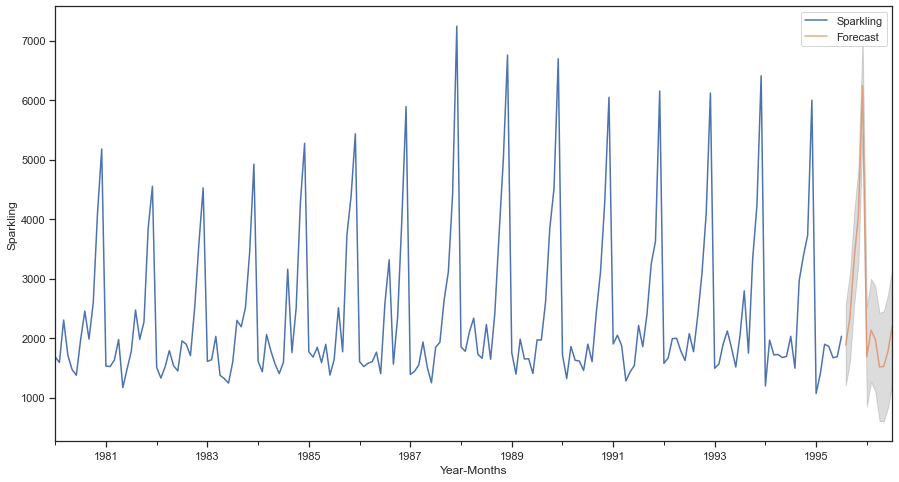

In [171]:
#Q9- plot the forecast along with the confidence band

axis = spark.plot(label='Observed', figsize=(15, 8))
forecast_fullmodel_autosarima_SARIMA_spark_full_cf.plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(forecast_fullmodel_autosarima_SARIMA_spark_full_cf.index, pred_ci_95_SARIMA_spark_full_cf['lower Sparkling'], pred_ci_95_SARIMA_spark_full_cf['upper Sparkling'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Sparkling')
plt.legend(loc='best')
plt.show()

In [172]:
#Q8
results_spark_RMSE = pd.concat([results_spark_Smoothing,results_spark_ARIMASARIMA])
results_spark_RMSE

,Test RMSE,Test MAPE
"Alpha=1,SimpleExponentialSmoothing",1275.081823,38.90
"Alpha=0.1,SimpleExponentialSmoothing",1375.393398,49.53
"Alpha=0.1,Beta=0.1,DoubleExponentialSmoothing",1778.564670,67.20
"Alpha=0.154,Beta=5.310e-21,Gamma=0.371,TripleExponentialSmoothing",383.157627,11.91
"Alpha=0.4,Beta=0.1,Gamma=0.2,TripleExponentialSmoothing",336.715250,10.56
RegressionOnTime,1389.135175,50.15
NaiveModel,3864.279352,152.87
SimpleAverageModel,1275.081804,38.90
2pointTrailingMovingAverage,813.400684,19.70
4pointTrailingMovingAverage,1156.589694,35.96
